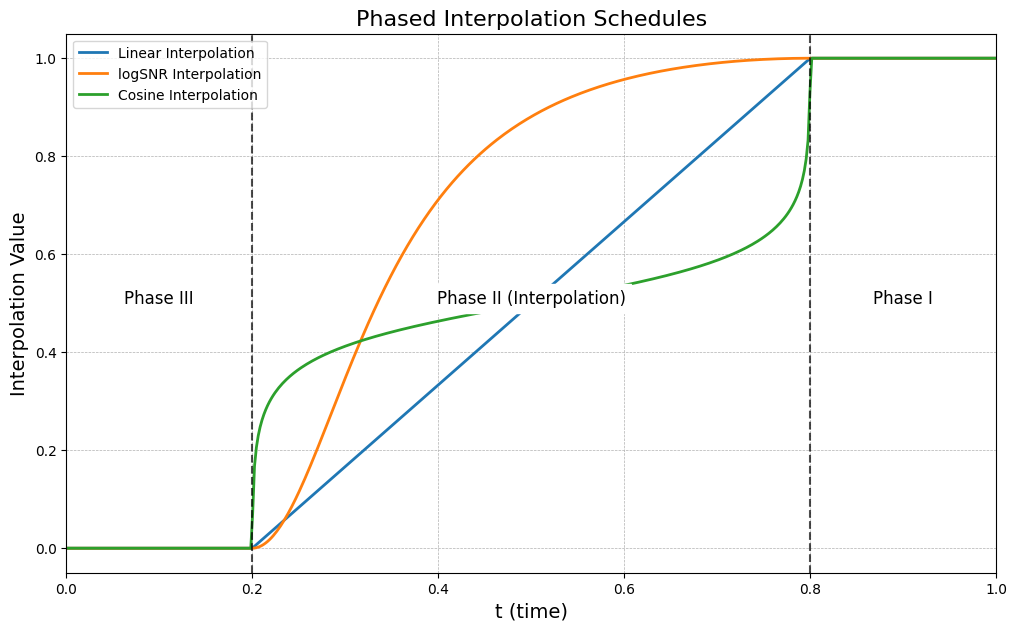

In [9]:
import matplotlib.pyplot as plt
import torch
import math
from torch import log

# This first part of the code is provided by the user.
# It defines the different normalized schedule functions.

def logsnr_schedule_cosine(t, logsnr_min=-15, logsnr_max=15):
	"""
	Base cosine schedule for logSNR.
	Maps t from [0, 1] to [logsnr_max, logsnr_min].
	"""
	t_min = math.atan(math.exp(-0.5 * logsnr_max))
	t_max = math.atan(math.exp(-0.5 * logsnr_min))
	return -2 * log(torch.tan(t_min + t * (t_max - t_min)))

class CosineScheduleNormalized:
	"""
	Normalized cosine schedule that maps t from [0, 1] to [0, 1].
	"""
	def __init__(self, logsnr_min=-15, logsnr_max=15):
		self.logsnr_min = logsnr_min
		self.logsnr_max = logsnr_max
		self.t_min = math.atan(math.exp(-0.5 * self.logsnr_max))
		self.t_max = math.atan(math.exp(-0.5 * self.logsnr_min))

	def __call__(self, t):
		# Reverse time, so that as t goes from 0 to 1,
		# the logSNR goes from min to max.
		t_rev = 1 - t
		logsnr = -2 * log(torch.tan(self.t_min + t_rev * (self.t_max - self.t_min)))
		# Normalize to [0, 1]
		return (logsnr - self.logsnr_min) / (self.logsnr_max - self.logsnr_min)


class SigmoidScheduleNormalized:
	"""
	Sigmoid schedule based on logSNR, normalized to [0, 1].
	"""
	def __init__(self, b=-2):
		self.b = b
		# We need the base logsnr function
		self.logsnr_fn = lambda t: logsnr_schedule_cosine(t)

	def __call__(self, t):
		# Reverse time
		t_rev = 1 - t
		logsnr = self.logsnr_fn(t_rev)
		# Apply sigmoid
		weight = (1 + (self.b - logsnr).exp()) ** -1
		return weight


class LinearScheduleNormalized:
	"""Linear schedule normalized to [0, 1]."""
	def __call__(self, t):
		return t

# --- My implementation to create the phased plot ---

def vectorized_phased_function(t_values, t_C, t_S, schedule):
    """
    Applies a schedule function over three phases defined by t_C and t_S.
    - Phase 1 (t < t_C): Output is 0.
    - Phase 2 (t_C <= t < t_S): Output is from the schedule, scaled to this interval.
    - Phase 3 (t >= t_S): Output is 1.
    """
    y_values = torch.zeros_like(t_values)

    # Phase 2 mask
    mask_phase2 = (t_values >= t_C) & (t_values < t_S)
    
    # Scale time for the interpolation interval [t_C, t_S] to [0, 1]
    t_scaled = (t_values[mask_phase2] - t_C) / (t_S - t_C)
    
    # Apply the schedule function
    y_values[mask_phase2] = schedule(t_scaled)

    # Phase 3 mask
    mask_phase3 = t_values >= t_S
    y_values[mask_phase3] = 1.0

    return y_values

# 1. Define parameters
# Chosen based on the visual representation in input_file_0.png
t_C = 0.2
t_S = 0.8
t_values = torch.linspace(0, 1, 500)

# 2. Instantiate schedules
linear_schedule = LinearScheduleNormalized()
sigmoid_schedule = SigmoidScheduleNormalized(b=-2)
cosine_schedule = CosineScheduleNormalized()

# 3. Compute y_values for each schedule using the phased function
y_linear = vectorized_phased_function(t_values, t_C, t_S, linear_schedule)
y_sigmoid = vectorized_phased_function(t_values, t_C, t_S, sigmoid_schedule)
y_cosine = vectorized_phased_function(t_values, t_C, t_S, cosine_schedule)

# 4. Plot the results
plt.figure(figsize=(12, 7))
plt.plot(t_values.numpy(), y_linear.numpy(), label="Linear Interpolation", linewidth=2)
plt.plot(t_values.numpy(), y_sigmoid.numpy(), label="logSNR Interpolation", linewidth=2)
plt.plot(t_values.numpy(), y_cosine.numpy(), label="Cosine Interpolation", linewidth=2)

# Add vertical lines and text to mark the phases
plt.axvline(x=t_C, color='k', linestyle='--', alpha=0.7)
plt.axvline(x=t_S, color='k', linestyle='--', alpha=0.7)
plt.text(t_C / 2, 0.5, 'Phase III', horizontalalignment='center', fontsize=12)
plt.text((t_S + t_C) / 2, 0.5, 'Phase II (Interpolation)', horizontalalignment='center', fontsize=12, backgroundcolor='white')
plt.text((1 + t_S) / 2, 0.5, 'Phase I', horizontalalignment='center', fontsize=12)

# Add labels, title, and legend
plt.xlabel("t (time)", fontsize=14)
plt.ylabel("Interpolation Value", fontsize=14)
plt.title("Phased Interpolation Schedules", fontsize=16)
plt.legend(loc="upper left")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(-0.05, 1.05)
plt.xlim(0, 1)

plt.show()


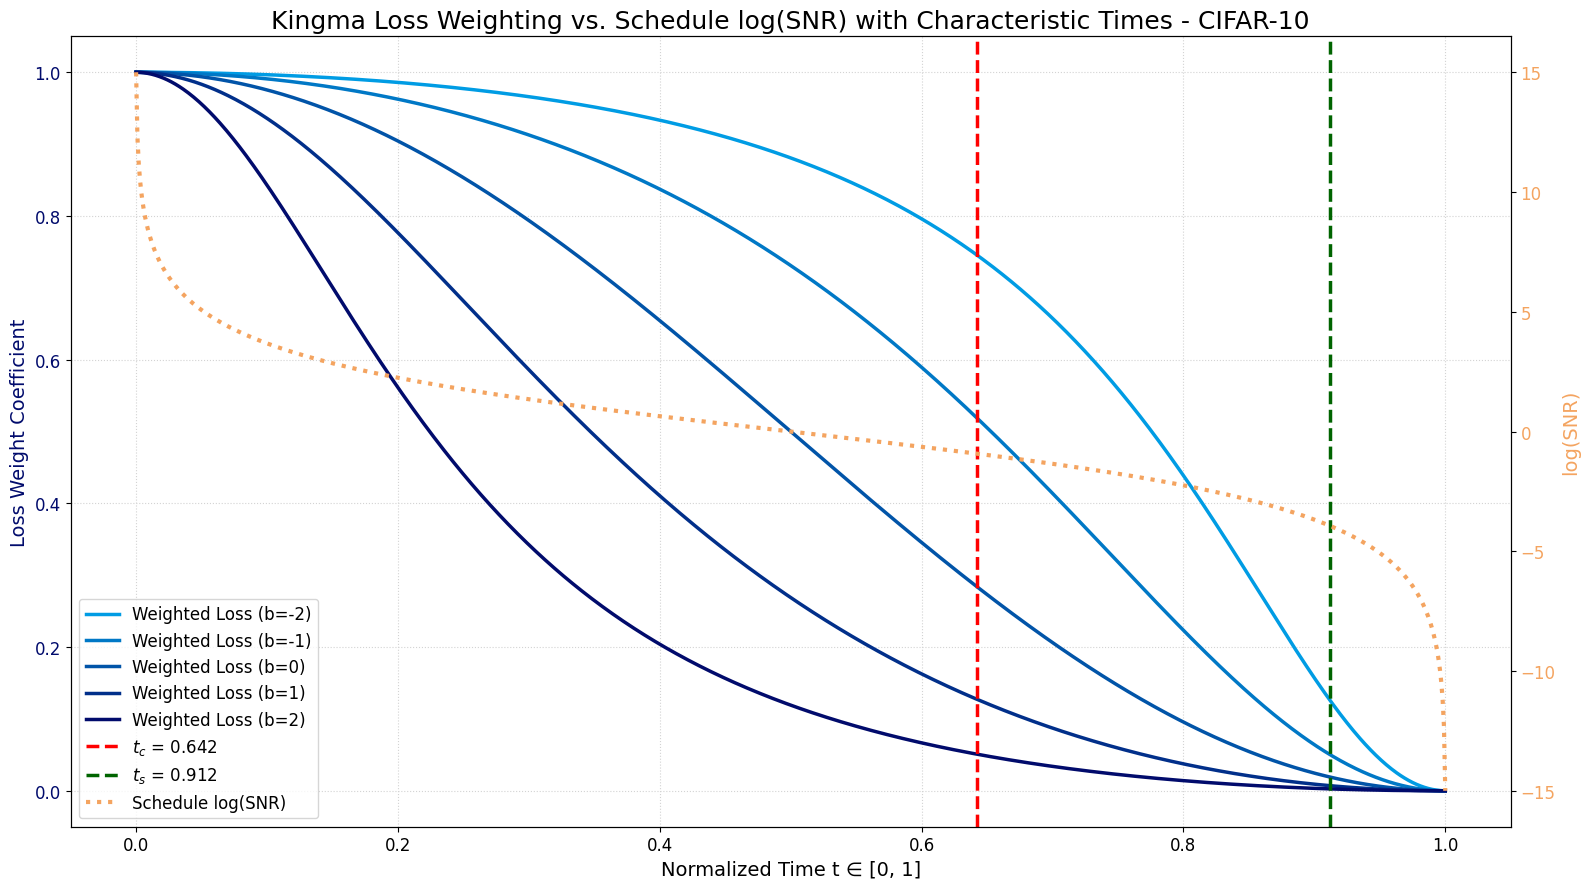

In [37]:
import torch
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def logsnr_schedule_cosine(t, logsnr_min=-15, logsnr_max=15):
    """
    Base cosine schedule for logSNR.
    Maps t from [0, 1] to [logsnr_max, logsnr_min].
    Note: Corrected to use torch functions for tensor operations.
    """
    t_min = torch.atan(torch.exp(-0.5 * torch.tensor(logsnr_max)))
    t_max = torch.atan(torch.exp(-0.5 * torch.tensor(logsnr_min)))
    # Use torch.log and torch.tan for tensor compatibility
    return (-2 * torch.log(torch.tan(t_min + t * (t_max - t_min)))).clamp(logsnr_min, logsnr_max)

# The class you provided, unchanged.
class KingmaSNRLossWeighting:
    """Kingma et al. (2021) SNR loss weighting."""
    def __init__(self, b=0):
        self.b = b

    def __call__(self, loss, schedule_t):
        logsnr = schedule_t["log_snr"]
        weight = (1 + (self.b - logsnr).exp()) ** -1
        return loss * weight

# 1. Generate the data for the plot
t = torch.linspace(0, 1, 1000)
log_snr = logsnr_schedule_cosine(t)

b_values = [-2, -1, 0, 1, 2]
weighted_losses = {}
loss_weigher = KingmaSNRLossWeighting()
for b in b_values:
    loss_weigher.b = b
    weight = (1 + (b - log_snr).exp())**-1
    weighted_losses[b] = weight

# 2. Create the plot with the new color scheme
fig, ax1 = plt.subplots(figsize=(16, 9))

# --- Color Scheme Setup ---
# REVISED: Hand-picked a 5-color blue gradient for perfect visibility
blue_gradient_colors = ['#009CE4', '#0078C6', '#0154A8', '#012F8A', '#010B6C']
# These colors correspond to b = -2, -1, 0, 1, 2 respectively

log_snr_color = '#F4A460' # SandyBrown, a pleasant orange
primary_axis_color = '#010B6C' # Match the darkest blue for axis labels

# Plot the weighted loss curves with the specified blue gradient
for i, b in enumerate(b_values):
    ax1.plot(t.numpy(), weighted_losses[b].numpy(), label=f'Weighted Loss (b={b})', color=blue_gradient_colors[i], linewidth=2.5)

# Configure the primary y-axis (left)
ax1.set_xlabel('Normalized Time t ∈ [0, 1]', fontsize=14)
ax1.set_ylabel('Loss Weight Coefficient', color=primary_axis_color, fontsize=14)
ax1.tick_params(axis='y', labelcolor=primary_axis_color, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(True, linestyle=':', color='lightgray')
ax1.set_ylim(-0.05, 1.05)
ax1.set_xlim(-0.05, 1.05)

# Create a secondary y-axis for the log(SNR) schedule
ax2 = ax1.twinx()
ax2.plot(t.numpy(), log_snr.numpy(), color=log_snr_color, linestyle=':', label='Schedule log(SNR)', linewidth=3)

# Configure the secondary y-axis (right)
ax2.set_ylabel('log(SNR)', color=log_snr_color, fontsize=14)
ax2.tick_params(axis='y', labelcolor=log_snr_color, labelsize=12)
ax2.set_ylim(-16.5, 16.5)

# Add the vertical characteristic time lines with specified colors
ax1.axvline(x=0.642, color='red', linestyle='--', linewidth=2.5, label=r'$t_c$ = 0.642')
ax1.axvline(x=0.912, color='darkgreen', linestyle='--', linewidth=2.5, label=r'$t_s$ = 0.912')

# Set the title
plt.title('Kingma Loss Weighting vs. Schedule log(SNR) with Characteristic Times - CIFAR-10', fontsize=18)

# Create a single, combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower left', fontsize=12)

fig.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Generate values for t
t_values = torch.linspace(0, 1, 500)

# Compute logsnr values
logsnr_values = logsnr_schedule_cosine(t_values)

# Plot the logsnr schedule
plt.plot(t_values.numpy(), logsnr_values.numpy())
plt.xlabel("t")
plt.ylabel("log SNR")
plt.title("Log SNR Schedule (Cosine)")
plt.grid(True)
plt.show()

In [ ]:
squared_alpha = torch.sqrt(logsnr_values.sigmoid())
squared_sigma = torch.sqrt((-logsnr_values).sigmoid())
squared_alpha_shifted = torch.sqrt(logsnr_values_shifted.sigmoid())
squared_sigma_shifted = torch.sqrt((-logsnr_values_shifted).sigmoid())
squared_alpha_interpolated = torch.sqrt(logsnr_values_interpolated.sigmoid())
squared_sigma_interpolated = torch.sqrt((-logsnr_values_interpolated).sigmoid())
# Plot the squared alpha and sigma
plt.plot(t_values.numpy(), squared_alpha.numpy(), label="Squared Alpha")
plt.plot(t_values.numpy(), squared_sigma.numpy(), label="Squared Sigma")
plt.plot(t_values.numpy(), squared_alpha_shifted.numpy(), label="Squared Alpha Shifted")
plt.plot(t_values.numpy(), squared_sigma_shifted.numpy(), label="Squared Sigma Shifted")
plt.plot(t_values.numpy(), squared_alpha_interpolated.numpy(), label="Squared Alpha Interpolated")
plt.plot(t_values.numpy(), squared_sigma_interpolated.numpy(), label="Squared Sigma Interpolated")
plt.xlabel("t")
plt.ylabel("Squared Values")
plt.title("Squared Alpha and Sigma")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from distributional_diffusion_timeseries.models.simple_diffusion import create_gaussian_diffusion

diffusion = create_gaussian_diffusion(image_size=32)

In [ ]:
sum(p.numel() for p in diffusion.model.parameters() if p.requires_grad)

In [ ]:
from composer.algorithms import EMA

EMA(half_life=None, smoothing=0.999, update_interval="1ba")

In [ ]:
from torchvision import datasets

digits = datasets.MNIST("./mnist", train=False, download=True)

In [11]:
import itertools
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
classes_pairs = itertools.combinations(classes, 2)
classes_pairs = list(classes_pairs)
classes_pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (6, 7),
 (6, 8),
 (6, 9),
 (7, 8),
 (7, 9),
 (8, 9)]

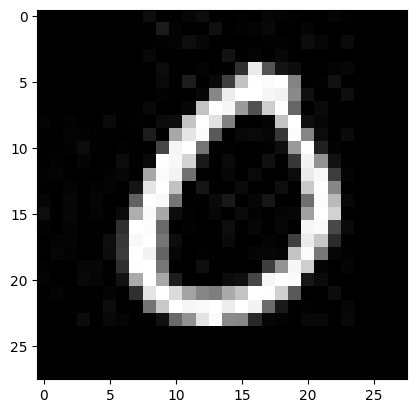

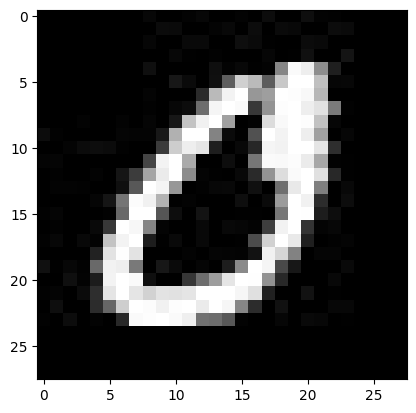

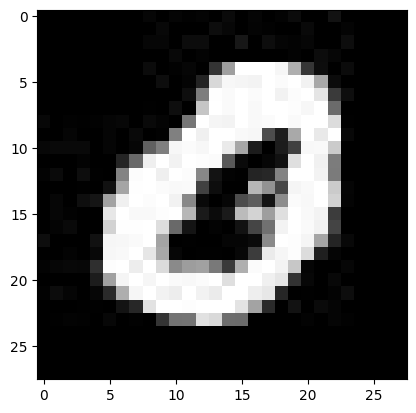

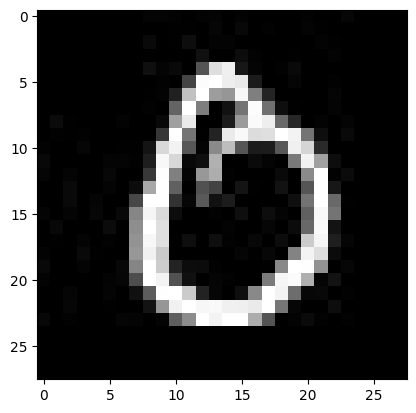

In [9]:
import distributional_diffusion_timeseries.datasets.image_loader as vl
from torchvision import transforms
from distributional_diffusion_timeseries.image_utils import tensor_to_gif_bytes
from IPython.display import display, Image as IPImage
import numpy as np
import torch
import matplotlib.pyplot as plt

dataloader = vl.build_streaming_image_dataloader(
	datadir="/tmp/martorellat/data/mnist/mds/train",
	batch_size=32,
	shuffle=False,
	image_size=28,
	num_channels=1,
	transform=[transforms.Grayscale(1), transforms.ToTensor()],
)

j=0
for i in np.random.permutation(len(dataloader.dataset)):
	if dataloader.dataset.get_full_element_by_index(i)["label"] == 0:
		img = dataloader.dataset[i]
		plt.imshow(img["image"][0].numpy(), cmap="gray")
		plt.show()
		j+=1

	if j >= 4:
		break

# for i in np.random.permutation(len(dataloader.dataset))[:4]:
# 	generated_gif_bytes = tensor_to_gif_bytes(
# 		tensor=dataloader.dataset[i]["image"],  # Pass the tensor here
# 		duration_ms=100,
# 		data_range=(0.0, 1.0),
# 	)

# 	display(IPImage(data=generated_gif_bytes))  # Display the generated GIF


In [12]:
imgs = [dataloader.dataset[i] for i in range(4)]

In [14]:
context = torch.stack(list(map(lambda x: x["image"], imgs)), dim=0)

In [17]:
imgs[0]["image"].shape, context.shape

(torch.Size([1, 28, 28]), torch.Size([4, 1, 28, 28]))

In [22]:
context[: None, ...].shape

torch.Size([4, 1, 28, 28])

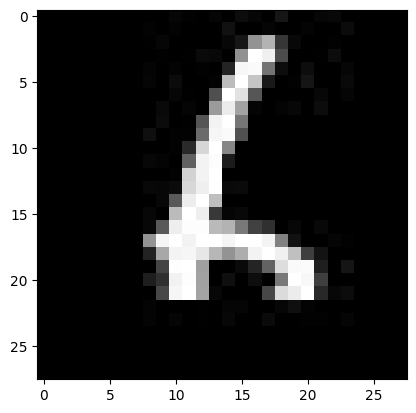

(21, 15)


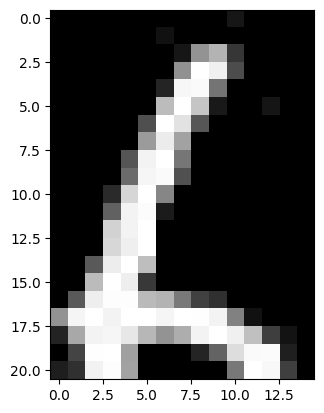

In [16]:
global_min_diff = 9999
global_max_diff = -1

iterator = dataloader.dataset
iterator = [15190]

for i in range(len(iterator)):
	img = dataloader.dataset[iterator[i]]
	# find bounding box of digit in image in mnist

	# convert to numpy
	img = img["image"].numpy()
	img = img[0]

	plt.imshow(img, cmap="gray")
	plt.show()

	img = img * 255
	img = img.astype(np.uint8)
	# find bounding box
	img[img < 16] = 0
	nonzero = np.nonzero(img)
	x_min = np.min(nonzero[1])
	x_max = np.max(nonzero[1])
	y_min = np.min(nonzero[0])
	y_max = np.max(nonzero[0])

	global_min_diff = min(global_min_diff, y_max - y_min)
	global_max_diff = max(global_max_diff, y_max - y_min)
	

	# crop image
	cropped_img = img[y_min:y_max, x_min:x_max]
	cropped_img = cropped_img.astype(np.uint8)
	print(cropped_img.shape)
	plt.imshow(cropped_img, cmap="gray")
	plt.show()
	if i > 5:
		break

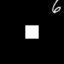

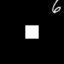

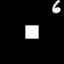

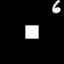

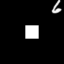

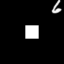

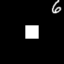

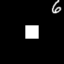

In [4]:
import distributional_diffusion_timeseries.datasets.video_loader as vl
from torchvision import transforms
from distributional_diffusion_timeseries.image_utils import tensor_to_gif_bytes
from IPython.display import display, Image as IPImage
import numpy as np

dataloader = vl.build_streaming_video_dataloader(
	datadir="/ceph/scratch/martorellat/data/hiding_moving_mnist_binary_all_6/mds/train",
	batch_size=32,
	shuffle=False,
	image_size=64,
	num_channels=1,
	num_frames=8,
	transform=[transforms.Grayscale(1), transforms.Resize(64), transforms.ToTensor()],
)

for i in range(len(dataloader.dataset))[:8]:
	generated_gif_bytes = tensor_to_gif_bytes(
		tensor=dataloader.dataset[i]["image"],  # Pass the tensor here
		duration_ms=100,
		data_range=(0.0, 1.0),
	)

	display(IPImage(data=generated_gif_bytes))  # Display the generated GIF


# generated_gif_bytes = tensor_to_gif_bytes(
# 	tensor=dataloader.dataset[558]["image"],  # Pass the tensor here
# 	duration_ms=100,
# 	data_range=(0.0, 1.0),
# )

# display(IPImage(data=generated_gif_bytes))  # Display the generated GIF

In [4]:
dataloader.dataset.get_full_element_by_index(558)


{'frame_000': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_001': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_002': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_003': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_004': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_005': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_006': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_007': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_008': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_009': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_010': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_011': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_012': <PIL.PngImagePlugin.PngImageFile image mode=L size=96x96>,
 'frame_013': <PIL.PngImagePlugin.PngImageFile imag

Detected image shape in batch: torch.Size([32, 16, 1, 96, 96])
Total items processed (images/frames): 79872
Shape of average image: torch.Size([1, 96, 96])


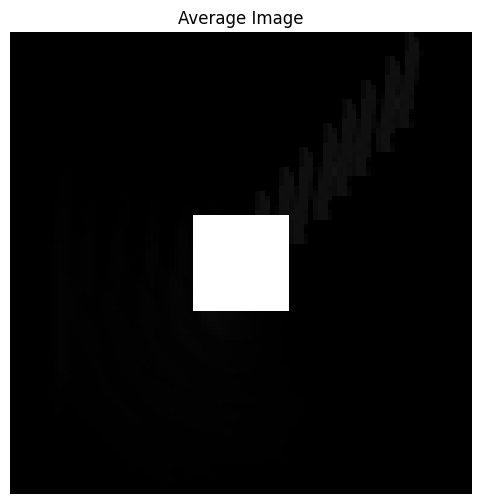

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming dataloader is already defined and loaded
# dataloader = vl.build_streaming_video_dataloader(...) # Or image_dataloader

# Get the shape of a single image from the first batch to initialize sum_images
first_batch = next(iter(dataloader))
# Assuming the image tensor is under the key 'image'
# And has shape (batch_size, num_channels, height, width) or (batch_size, num_frames, num_channels, height, width) for video
# For averaging, we'll average over the batch dimension.
# If it's video, we can average over frames too, or pick one. Let's average over frames for now if it's video.

image_shape = first_batch['image'].shape
print(f"Detected image shape in batch: {image_shape}")

if len(image_shape) == 5: # (batch, frames, channels, height, width) - video
    # Let's average over frames as well for simplicity, or one could select a specific frame
    # For averaging over frames, the sum_images will be (channels, height, width)
    # We will sum up all frames of all videos
    sum_images = torch.zeros(image_shape[2:]) # C, H, W
    total_images = 0 # This will count total frames
elif len(image_shape) == 4: # (batch, channels, height, width) - image
    sum_images = torch.zeros(image_shape[1:]) # C, H, W
    total_images = 0 # This will count total images
else:
    raise ValueError(f"Unsupported image shape: {image_shape}")


# Reset dataloader iterator or create a new one if it's exhausted
# For StreamingDataset, it can be iterated multiple times
for batch_data in dataloader:
    images = batch_data['image'] # N, C, H, W or N, F, C, H, W
    if images.is_mps: # Move to CPU for sum and display if on MPS
        images = images.cpu()
    
    if len(image_shape) == 5: # Video
        # Sum over batch and frames dimension
        sum_images += torch.sum(images, dim=0)
        total_images += images.shape[0] # batch_size
    elif len(image_shape) == 4: # Image
        # Sum over batch dimension
        sum_images += torch.sum(images, dim=0)
        total_images += images.shape[0] # batch_size

if total_images > 0:
    average_image = sum_images / total_images 
    
    print(f"Total items processed (images/frames): {total_images}")
    print(f"Shape of average image: {average_image.shape}")

    # Display the average image
    plt.figure(figsize=(6, 6))
    
    # Squeeze out channel dimension if it's 1 (grayscale)
    img_to_show = average_image.squeeze()
    
    # If after squeeze it's still 3D (e.g. C, H, W with C > 1), permute for imshow (H, W, C)
    if img_to_show.ndim == 3 and img_to_show.shape[0] in [1, 3]: # Assuming C is the first dim
        img_to_show = img_to_show.permute(1, 2, 0)
        if img_to_show.shape[2] == 1: # If it was (1, H, W) and permuted to (H, W, 1)
             img_to_show = img_to_show.squeeze(dim=2)


    plt.imshow(img_to_show.numpy(), cmap='gray' if img_to_show.ndim == 2 or img_to_show.shape[-1] == 1 else None)
    plt.title("Average Image")
    plt.axis('off')
    plt.show()
else:
    print("No images found in the dataloader.")


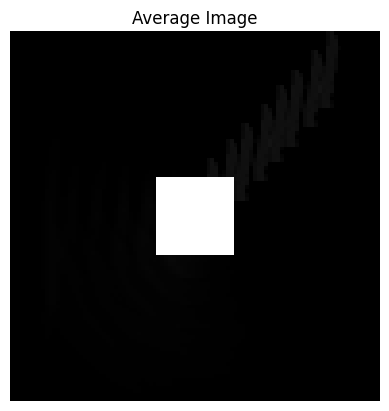

In [15]:
plt.imshow(sum_images.squeeze().numpy() * 128, cmap="gray" if img_to_show.ndim == 2 or img_to_show.shape[-1] == 1 else None)
plt.title("Average Image")
plt.axis('off')
plt.show()

Detected image shape in batch: torch.Size([32, 16, 1, 96, 96])


100%|██████████| 156/156 [00:17<00:00,  8.93it/s]


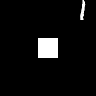

In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

first_batch = next(iter(dataloader))
image_shape = first_batch["image"].shape
print(f"Detected image shape in batch: {image_shape}")

sum_images = torch.zeros(image_shape[1:])  # T, C, H, W
total_images = 0  # This will count total frames

for batch_data in tqdm(dataloader):
	images = batch_data["image"]  # N, C, H, W or N, F, C, H, W
	sum_images += torch.sum(images, dim=0)
	total_images += images.shape[0]  # batch_size

generated_gif_bytes = tensor_to_gif_bytes(
	tensor=sum_images,  # Pass the tensor here
	duration_ms=100,
	data_range=(sum_images.min().item(), sum_images.max().item()),
)

display(IPImage(data=generated_gif_bytes))  # Display the generated GIF


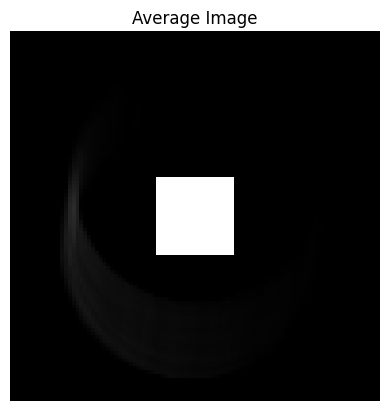

In [32]:
plt.imshow(
	sum_images[13].squeeze().numpy(), cmap="gray" if img_to_show.ndim == 2 or img_to_show.shape[-1] == 1 else None
)
plt.title("Average Image")
plt.axis("off")
plt.show()


In [29]:
c

4

In [ ]:
from distributional_diffusion_timeseries.models.uvit import UViT

model = UViT(
	image_size=32,
	dim=64,
	channels=1,
	vit_depth=4,
	dim_mults=(1, 2, 4),
	num_resnet_blocks=(2, 2, 2),
	attn_dim_head=64,
	attn_heads=4,
	ff_mult=4,
	learned_sinusoidal_dim=16,
)


# calculate the number of parameters in the model
def count_parameters(model):
	return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(model)

8101257

In [2]:
import torch

model(torch.randn(4, 1, 32, 32), torch.rand((4)).float().uniform_(0, 1))

tensor([[[[ 0.4990,  0.2204,  0.2411,  ...,  0.1353, -0.0912, -0.1404],
          [ 0.8043,  0.5179,  0.3625,  ..., -0.0363,  0.0664,  0.1741],
          [ 0.4959,  0.4631,  0.3068,  ...,  0.4161,  0.3825,  0.8200],
          ...,
          [-0.0141, -0.2005,  0.0194,  ...,  0.7672,  0.2284,  0.0465],
          [-0.1326,  0.3243,  0.1347,  ..., -0.0295,  0.0800,  0.1287],
          [-0.0098,  0.2463,  0.0175,  ..., -0.1812,  0.0629,  0.1791]]],


        [[[-0.1785, -0.3047, -0.0980,  ...,  0.3414,  0.2452,  0.2140],
          [-0.2906, -0.1307, -0.0151,  ...,  0.5101,  0.4924,  0.5297],
          [-0.1012,  0.0481,  0.0957,  ...,  0.3192,  0.7076,  1.0435],
          ...,
          [-0.0132, -0.0250,  0.2433,  ...,  0.3223,  1.2464,  0.6895],
          [ 0.0207, -0.2810, -0.2387,  ...,  0.2732,  0.2717,  0.4087],
          [-0.2097, -0.2426, -0.3130,  ...,  0.4980,  0.5185,  0.4565]]],


        [[[ 0.3249,  0.1690,  0.1593,  ..., -0.6176, -0.4798, -0.3910],
          [ 0.3238, -0.044

In [12]:
from einops import rearrange, repeat
import torch

a = torch.tensor([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
print(a.shape)

x = rearrange(a, "a b c -> (a b) c")

print(x.shape)
print(x[:, 0])

b = rearrange(x, "(a b) c -> a b c", a=a.shape[0])

print(b.shape)

print((b == a).all())

torch.Size([2, 3, 3])
torch.Size([6, 3])
tensor([1, 4, 7, 1, 4, 7])
torch.Size([2, 3, 3])
tensor(True)


In [1]:
from distributional_diffusion_timeseries.models.diffusions.scoring_rules import *

energy_score_fn = GeneralizedKernelScore(energy_kernel, lambda_val=1.0, scoring_rule_kwargs={"beta": 2})


Failed to import dit during registration: cannot import name 'CaptionProjection' from 'distributional_diffusion_timeseries.models.utils' (/Users/tommymarto/Documents/dev/distributional_diffusion_timeseries/distributional_diffusion_timeseries/models/utils.py)
Failed to import latent_diffusion during registration: cannot import name 'dit' from partially initialized module 'distributional_diffusion_timeseries.models' (most likely due to a circular import) (/Users/tommymarto/Documents/dev/distributional_diffusion_timeseries/distributional_diffusion_timeseries/models/__init__.py)
Failed to import simple_diffusion2 during registration: invalid syntax (simple_diffusion2.py, line 289)


In [2]:
x = torch.randn(64, 64, 32, 32).clamp(-1, 1)
y = torch.randn(64, 64, 32, 32).clamp(-1, 1)

energy_score_fn(x, y)

Value(False)


tensor([-529.6403, -525.9266, -525.7936, -525.2571, -521.6069, -524.3163,
        -529.0858, -526.3947, -531.8760, -535.1992, -516.1688, -532.7708,
        -529.2479, -527.9267, -529.0149, -517.0458, -530.6550, -532.5944,
        -537.5516, -528.5448, -529.6772, -533.6948, -525.2889, -527.5662,
        -532.8201, -532.3723, -533.9017, -526.8425, -532.2491, -526.2970,
        -529.3982, -523.8967, -534.5031, -528.3686, -522.6027, -522.8180,
        -526.5911, -526.4815, -522.9047, -532.5413, -527.7776, -520.9267,
        -525.6428, -528.1104, -521.9384, -523.2755, -529.8252, -524.0244,
        -533.6929, -540.1743, -518.8729, -526.6848, -522.5997, -523.4465,
        -521.5798, -523.0053, -533.4928, -528.5071, -529.7333, -532.2100,
        -528.7308, -527.0931, -531.3363, -532.6049])

In [2]:
import torch
from einops import rearrange, repeat
torch.tensor([1, 2, 3]).repeat(2)

tensor([1, 2, 3, 1, 2, 3])

In [3]:
repeat(torch.tensor([1, 2, 3]), "-> b", b=2)

EinopsError:  Error while processing repeat-reduction pattern "-> b".
 Input tensor shape: torch.Size([3]). Additional info: {'b': 2}.
 Wrong shape: expected 0 dims. Received 1-dim tensor.

In [2]:
import torch
import torch.nn as nn
# Assuming 'your_model_class' is the class of the model you pass to Composer
# from your_project import your_model_class


# --- Define a simple placeholder if your model is complex ---
class SimpleModelForTest(nn.Module):
	def __init__(self):
		super().__init__()
		self.linear = nn.Linear(10, 1)

	def forward(self, x):  # Match the input signature your actual model expects
		return self.linear(x)


# -----------------------------------------------------------

if torch.backends.mps.is_available():
	device = torch.device("mps")
	print(f"PyTorch Version: {torch.__version__}")
	print(f"Testing manual torch.compile on device: {device}")

	# Instantiate your model (or the SimpleModelForTest)
	# model_instance = your_model_class() # Or however you instantiate it
	model_instance = SimpleModelForTest()
	model_instance = model_instance.to(device)
	model_instance.eval()  # Good practice

	# Create a dummy input that matches your model's expected input
	# This needs to be appropriate for your_model_class
	dummy_input = torch.randn(1, 10, device=device)  # For SimpleModelForTest
	# For your actual model, ensure batch_size and other dimensions are correct
	# e.g., dummy_input = torch.randn(BATCH_SIZE, CHANNELS, HEIGHT, WIDTH, device=device)

	try:
		print("Attempting torch.compile manually with backend='inductor'...")
		compiled_model_manual = torch.compile(model_instance, backend="inductor")
		print("Manual torch.compile successful!")
		with torch.no_grad():
			output = compiled_model_manual(dummy_input)
		print(f"Output from manually compiled model: {output.shape}, device: {output.device}")
	except Exception as e:
		print(f"Manual torch.compile failed: {e}")
		import traceback

		traceback.print_exc()
else:
	print("MPS device not available for manual test.")


PyTorch Version: 2.6.0
Testing manual torch.compile on device: mps
Attempting torch.compile manually with backend='inductor'...
Manual torch.compile successful!
Manual torch.compile failed: backend='inductor' raised:
AssertionError: Device mps not supported

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True



Traceback (most recent call last):
  File "/var/folders/l0/gt9svnws67l46fnhkn9s_mpr0000gn/T/ipykernel_83003/1419586583.py", line 41, in <module>
    output = compiled_model_manual(dummy_input)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tommymarto/Documents/dev/distributional_diffusion_timeseries/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tommymarto/Documents/dev/distributional_diffusion_timeseries/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tommymarto/Documents/dev/distributional_diffusion_timeseries/.venv/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py", line 574, in _fn
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/tommymarto/Docum

In [3]:
torch.backends.opt_einsum.is_available()

AttributeError: module 'torch.backends' has no attribute 'opt_einsum'

In [67]:
import distributional_diffusion_timeseries.datasets.image_loader as vl
from torchvision import transforms
from distributional_diffusion_timeseries.image_utils import tensor_to_gif_bytes
from IPython.display import display, Image as IPImage
import numpy as np
import matplotlib.pyplot as plt
import torch

b = 512
dataloader = vl.build_streaming_image_dataloader(
	datadir="./data/mnist/mds/test",
	batch_size=b,
	shuffle=False,
	image_size=32,
	num_channels=1,
	transform=[transforms.Grayscale(1), transforms.Pad(2), transforms.ToTensor()],
)
m_squared_list = []
m_list = []

for i, x in enumerate(iter(dataloader)):
	img = x["image"]

	# compute m^2 = ||x-x'||^2 where x' is every other image in the batch
	dist = torch.cdist(img.view(b, -1), img.view(b, -1), p=2)
	y = torch.triu(torch.pow(dist, 2))
	m_squared = y.sum() / sum(range(b))
	m_squared_list.append(m_squared.item())
	# print(f"m^2 = {m_squared.item()}")

	y = torch.triu(dist)
	m = y.sum() / sum(range(b))
	m_list.append(m.item())
	# print(f"m = {m.item()}")

	if i == 100:
		break

# print median of m^2
print(f"m^2 = {np.median(m_squared_list)}")
# print median of m
print(f"m = {np.median(m_list)}")

m^2 = 98.01052856445312
m = 9.795403480529785


In [44]:
x = torch.randn(4, 3, 32, 32)
sus = 4
# x = torch.stack([x], dim=0)
# for i in range(sus):
#     x[i] = x[i] * (i+11)

print(torch.pow(torch.norm((x[0] - x[1]).view(sus, -1), p=2), 2))
print(((x[0] - x[1])**2).sum())
print(torch.pow(torch.cdist(x.view(sus, -1), x.view(sus, -1), p=2), 2))

tensor(6057.5649)
tensor(6057.5625)
tensor([[   0.0000, 6057.5566, 6120.2666, 6243.9150],
        [6057.5566,    0.0000, 5921.9209, 5856.0430],
        [6120.2666, 5921.9209,    0.0000, 6060.8003],
        [6243.9150, 5856.0430, 6060.8003,    0.0000]])


In [60]:
y = torch.triu(torch.pow(torch.cdist(x.view(sus, -1), x.view(sus, -1), p=2), 2))
print(y)
y.sum() / sum(range(sus))

tensor([[   0.0000, 6057.5566, 6120.2666, 6243.9150],
        [   0.0000,    0.0000, 5921.9209, 5856.0430],
        [   0.0000,    0.0000,    0.0000, 6060.8003],
        [   0.0000,    0.0000,    0.0000,    0.0000]])


tensor(6043.4165)

In [59]:
sum(range(4))


6

In [1]:
from distributional_diffusion_timeseries.models.diffusions.schedules import LinearSchedule, CosineSchedule
import torch

l = LinearSchedule()
l = CosineSchedule()

Failed to import dit during registration: cannot import name 'CaptionProjection' from 'distributional_diffusion_timeseries.models.utils' (/Users/tommymarto/Documents/dev/distributional_diffusion_timeseries/distributional_diffusion_timeseries/models/utils.py)
Failed to import latent_diffusion during registration: cannot import name 'dit' from partially initialized module 'distributional_diffusion_timeseries.models' (most likely due to a circular import) (/Users/tommymarto/Documents/dev/distributional_diffusion_timeseries/distributional_diffusion_timeseries/models/__init__.py)
Failed to import simple_diffusion2 during registration: invalid syntax (simple_diffusion2.py, line 289)


In [2]:
l(torch.linspace(0, 1, 11))

{'alpha': tensor([1.0000e+00, 9.8762e-01, 9.5095e-01, 8.9091e-01, 8.0895e-01, 7.0711e-01,
         5.8787e-01, 4.5419e-01, 3.0933e-01, 1.5687e-01, 5.5309e-04]),
 'sigma': tensor([5.5308e-04, 1.5687e-01, 3.0933e-01, 4.5419e-01, 5.8787e-01, 7.0711e-01,
         8.0895e-01, 8.9091e-01, 9.5095e-01, 9.8762e-01, 1.0000e+00]),
 'squared_sigma': tensor([3.0590e-07, 2.4609e-02, 9.5687e-02, 2.0629e-01, 3.4560e-01, 5.0000e-01,
         6.5440e-01, 7.9371e-01, 9.0431e-01, 9.7539e-01, 1.0000e+00]),
 'snr': tensor([3.2690e+06, 3.9636e+01, 9.4508e+00, 3.8476e+00, 1.8935e+00, 1.0000e+00,
         5.2811e-01, 2.5990e-01, 1.0581e-01, 2.5230e-02, 3.0591e-07]),
 'log_snr': tensor([ 1.5000e+01,  3.6797e+00,  2.2461e+00,  1.3475e+00,  6.3845e-01,
          1.1921e-07, -6.3845e-01, -1.3475e+00, -2.2461e+00, -3.6797e+00,
         -1.5000e+01])}

In [4]:
l(torch.tensor(0))

{'alpha': tensor(1.0000),
 'sigma': tensor(0.0006),
 'squared_sigma': tensor(3.0590e-07),
 'snr': tensor(3269017.5000),
 'log_snr': tensor(15.)}

In [12]:
import torch
import torch.nn as nn
from distributional_diffusion_timeseries.models.layers.cnn import FeedForward
from einops import rearrange, repeat

# Define the layer
l = FeedForward(dim=256, mult=4, cond_dim=256, dropout=0)

# Create input x
x = torch.randn(8, 16, 256)
t = torch.randn(4, 256)
t_1 = repeat(t, "b ... -> (b t) ...", t=2)

# Create x_prime by reshaping x
# Common ways to reshape while preserving element order for this purpose:
# x_prime = x.reshape(4, 32, 256) # Standard reshape
x_prime = x.contiguous().view(4, 32, 256).clone()  # Another common way

# Apply the layer
out_x = l(x, t_1)
out_x_prime = l(x_prime, t)

print("Shape of x:", x.shape)
print("Shape of x_prime:", x_prime.shape)
print("-" * 30)
print("Shape of l(x):", out_x.shape)
print("Shape of l(x_prime):", out_x_prime.shape)
print("-" * 30)

# Reshape the outputs to compare their content
out_x_flat = out_x.reshape(-1, 1024)
out_x_prime_flat = out_x_prime.reshape(-1, 1024)

print("Shape of l(x) flattened:", out_x_flat.shape)
print("Shape of l(x_prime) flattened:", out_x_prime_flat.shape)
print("-" * 30)

# Check if the flattened contents are the same
are_contents_equal = torch.allclose(out_x_flat, out_x_prime_flat)
print("Are the contents of the flattened outputs (approximately) equal?", are_contents_equal)

# Also, let's check the source vectors
x_flat = x.reshape(-1, 256)
x_prime_flat = x_prime.reshape(-1, 256)
print("Are the contents of the flattened inputs equal?", torch.allclose(x_flat, x_prime_flat))


Shape of x: torch.Size([8, 16, 256])
Shape of x_prime: torch.Size([4, 32, 256])
------------------------------
Shape of l(x): torch.Size([8, 16, 256])
Shape of l(x_prime): torch.Size([4, 32, 256])
------------------------------
Shape of l(x) flattened: torch.Size([32, 1024])
Shape of l(x_prime) flattened: torch.Size([32, 1024])
------------------------------
Are the contents of the flattened outputs (approximately) equal? True
Are the contents of the flattened inputs equal? True


In [1]:
import pandas as pd

pd.read_parquet("/tmp/martorellat/data/moving_mnist/raw/test_manifest.parquet").head()

,video_idx,frame_paths,labels,original_digit_paths
0,0,"[moving_mnist/raw/all/00000/000.png, moving_mn...","[6, 2]",[/tmp/martorellat/data/mnist/test/test_06252.p...
1,1,"[moving_mnist/raw/all/00001/000.png, moving_mn...","[3, 7]",[/tmp/martorellat/data/mnist/test/test_01731.p...
2,2,"[moving_mnist/raw/all/00002/000.png, moving_mn...","[2, 2]",[/tmp/martorellat/data/mnist/test/test_04521.p...
3,3,"[moving_mnist/raw/all/00003/000.png, moving_mn...","[3, 4]",[/tmp/martorellat/data/mnist/test/test_00576.p...
4,4,"[moving_mnist/raw/all/00004/000.png, moving_mn...","[7, 6]",[/tmp/martorellat/data/mnist/test/test_06363.p...


In [2]:
import torch
torch._inductor.list_options()

['TYPE_CHECKING',
 'enable_auto_functionalized_v2',
 'debug',
 'disable_progress',
 'verbose_progress',
 'fx_graph_cache',
 'fx_graph_remote_cache',
 'bundle_triton_into_fx_graph_cache',
 'autotune_local_cache',
 'autotune_remote_cache',
 'bundled_autotune_remote_cache',
 'force_disable_caches',
 'sleep_sec_TESTING_ONLY',
 'custom_op_default_layout_constraint',
 'triton_kernel_default_layout_constraint',
 'cpp_wrapper',
 'c_shim_version',
 'dce',
 'static_weight_shapes',
 'size_asserts',
 'nan_asserts',
 'pick_loop_orders',
 'inplace_buffers',
 'allow_buffer_reuse',
 'memory_planning',
 'memory_pool',
 'benchmark_harness',
 'epilogue_fusion',
 'epilogue_fusion_first',
 'pattern_matcher',
 'b2b_gemm_pass',
 'post_grad_custom_pre_pass',
 'post_grad_custom_post_pass',
 'joint_custom_pre_pass',
 'joint_custom_post_pass',
 'pre_grad_custom_pass',
 '_pre_fusion_custom_pass',
 'split_cat_fx_passes',
 'efficient_conv_bn_eval_fx_passes',
 'is_predispatch',
 'group_fusion',
 'batch_fusion',
 'pr

In [1]:
import torch

torch.rand((2, 4)).to("bfloat16").to("cuda")

RuntimeError: Invalid device string: 'bfloat16'

In [3]:
from distributional_diffusion_timeseries.models.architectures.uvit import UViT_XS
import torch

model = UViT_XS(image_size=32, attn_kind="SDPAttention")

batch_size = 128
x = torch.randn(batch_size, 3, 32, 32)
t = torch.rand((batch_size)).float().uniform_(0, 1)

In [4]:
%%timeit -n 10 -r 3
model(x, t)

756 ms ± 13.1 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [5]:
model2 = UViT_XS(
	image_size=32,
)

batch_size = 128
x2 = torch.randn(batch_size, 3, 32, 32)
t2 = torch.rand((batch_size)).float().uniform_(0, 1)

In [6]:
%%timeit -n 10 -r 3
model2(x2, t2)


734 ms ± 10.8 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [16]:
import time

n = 10  # Number of executions per repeat
r = 3  # Number of repeats

times = []
for _ in range(r):
	start = time.perf_counter()
	for _ in range(n):
		model(x, t)
	end = time.perf_counter()
	times.append((end - start) / n)

print(f"Average time per call over {r} repeats of {n} executions: {sum(times) / len(times):.6f} seconds")

Average time per call over 3 repeats of 10 executions: 0.598997 seconds


In [15]:
torch.random.manual_seed(42)
out = model(x, t)
torch.random.manual_seed(42)
out2 = model2(x2, t2)
print(out.allclose(out2))

False


In [79]:
out.is_contiguous(memory_format=torch.channels_last)

True

In [80]:
out2.is_contiguous(memory_format=torch.channels_last)

True

In [1]:
import torch
from einops import rearrange, reduce, repeat
from distributional_diffusion_timeseries.models.diffusions.scoring_rules import GeneralizedKernelScore, energy_kernel

gks = GeneralizedKernelScore(kernel_function=energy_kernel, lambda_val=1, population_size=3, scoring_rule_kwargs={"beta": 0.5})

x = torch.randn(4, 3, 1, 32, 32)
y = torch.randn(4, 3, 1, 32, 32)

print(gks.compute_rho(x, y))
print(gks.compute_rho_new(x, y))

tensor([0.9785, 0.9883, 0.9838, 0.9906])
tensor([0.9785, 0.9883, 0.9838, 0.9906])


In [ ]:
from typing import Tuple

class GeneralizedKernelScoreSimple:
	def __init__(
		self,
		kernel_function,
		lambda_val: float,
		population_size: int,
		# These must be tuples of Python ints, known at compile time
		# Represents the shape of a single feature vector in the population, e.g., (C, H, W) or (D,)
		input_feature_shape: Tuple[int, ...],
		# Represents the shape of the kernel output's feature part for a single pair
		# e.g., if kernel( (C,H,W), (C,H,W) ) -> (H,W), then this is (H,W)
		# if kernel( (C,H,W), (C,H,W) ) -> scalar, then this is ()
		kernel_output_feature_shape: Tuple[int, ...],
		scoring_rule_kwargs: dict,
	):
		self.kernel_function = kernel_function
		self.lambda_val = lambda_val

		assert isinstance(population_size, int) and population_size >= 0, (
			f"population_size must be a non-negative int, got {population_size}"
		)
		self.population_size: int = population_size

		assert isinstance(input_feature_shape, tuple) and all(
			isinstance(d, int) and d >= 0 for d in input_feature_shape
		), f"input_feature_shape must be a tuple of non-negative ints, got {input_feature_shape}"
		self.input_feature_shape: Tuple[int, ...] = input_feature_shape

		assert isinstance(kernel_output_feature_shape, tuple) and all(
			isinstance(d, int) and d >= 0 for d in kernel_output_feature_shape
		), f"kernel_output_feature_shape must be a tuple of non-negative ints, got {kernel_output_feature_shape}"
		self.kernel_output_feature_shape: Tuple[int, ...] = kernel_output_feature_shape

		self.scoring_rule_kwargs = scoring_rule_kwargs

		assert lambda_val >= 0.0, "Lambda value must be non-negative."
		if self.lambda_val > 0:
			assert self.population_size > 1, "If lambda_val > 0, population_size must be > 1."
		# If lambda_val == 0, population_size can be anything >= 0.
		# (compute_rho handles m=0 or m=1 by returning zeros if lambda_val > 0 was intended but m is small)

		# New approach: Directly construct selected_j and selected_j_prime
		# Since m is a Python constant, these loops will be unrolled by Dynamo,
		# and selected_j, selected_j_prime will be constant tensors with fixed shapes.
		s_j_list = []
		s_j_prime_list = []
		for j_val in range(population_size):
			for j_prime_val in range(population_size):
				if j_val != j_prime_val:
					s_j_list.append(j_val)
					s_j_prime_list.append(j_prime_val)

		# These tensors will have a fixed shape (m*(m-1),) known at compile time.
		self.selected_j = torch.tensor(s_j_list, dtype=torch.long)
		self.selected_j_prime = torch.tensor(s_j_prime_list, dtype=torch.long)

	def compute_rho(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
		m: int = self.population_size  # Python constant
		n: int = x.shape[0]  # Batch size, can be symbolic

		# Eager checks for correct input shapes based on __init__ params.
		# For torch.compile, these shape properties should be invariants or handled by guards.
		# Note: x.shape[2:] == self.input_feature_shape might be too strict if x comes from a view.
		# It's safer to rely on the caller to provide x with dimensions
		# (n, self.population_size, *self.input_feature_shape)
		# if x.shape[1] != m:
		#     raise ValueError(f"Input x.shape[1] ({x.shape[1]}) does not match population_size ({m})")
		# if x.shape[2:] != self.input_feature_shape:
		#    raise ValueError(f"Input x feature shape ({x.shape[2:]}) does not match expected ({self.input_feature_shape})")

		if n == 0:  # Guard for n == 0
			return torch.empty((0,), device=x.device, dtype=x.dtype)

		# This branch is taken if m is 0 or 1. 'm' is a Python constant here.
		if m <= 1:
			# If lambda_val > 0, __init__ ensures m > 1, so this branch is effectively dead code for that case.
			# If lambda_val == 0, m can be 0 or 1. Result is sum over empty set of pairs -> 0.
			return torch.zeros((n,), device=x.device, dtype=x.dtype)

		# --- From here, m is a Python constant > 1, and n is > 0 (symbolically) ---

		# idx_range = torch.arange(m, device=x.device)
		# grid_j, grid_j_prime = torch.meshgrid(idx_range, idx_range, indexing="ij")
		# mask_neq = grid_j != grid_j_prime  # Constant tensor

		# selected_j = grid_j[mask_neq]  # Constant tensor
		# selected_j_prime = grid_j_prime[mask_neq]  # Constant tensor

		x_p1 = x[:, self.selected_j]  # Shape: (n, const_num_pairs, *self.input_feature_shape)
		y_p1 = y[:, self.selected_j_prime]  # Shape: (n, const_num_pairs, *self.input_feature_shape)

		torch._check_is_size(x_p1.shape[1])
		torch._check_is_size(y_p1.shape[1])
		const_num_pairs: int = m * (m - 1)  # Python constant, > 0
		torch._check(x_p1.shape[1] == const_num_pairs, "x_p1 must have second dimension equal to m * (m - 1)")
		torch._check(y_p1.shape[1] == const_num_pairs, "y_p1 must have second dimension equal to m * (m - 1)")

		# Construct target shape for kernel input: (n * const_num_pairs, *self.input_feature_shape)
		# target_dim0_for_kernel is (Symbolic n * PythonInt const_num_pairs)
		target_dim0_for_kernel = n * const_num_pairs
		# kernel_input_shape is (SymInt*Int, Int, Int, ...) - all Ints are from self.input_feature_shape
		kernel_input_shape: Tuple = (target_dim0_for_kernel,) + self.input_feature_shape

		x_for_kernel = x_p1.reshape(kernel_input_shape)
		y_for_kernel = y_p1.reshape(kernel_input_shape)

		rho_values_all_filtered = self.kernel_function(x_for_kernel, y_for_kernel, **self.scoring_rule_kwargs)
		# Expected rho_values_all_filtered shape: (n * const_num_pairs, *self.kernel_output_feature_shape)

		# Construct target shape for reduction input: (n, const_num_pairs, *self.kernel_output_feature_shape)
		reduce_input_shape: Tuple = (n, const_num_pairs) + self.kernel_output_feature_shape
		rho_values_per_sample_pairs = rho_values_all_filtered.reshape(reduce_input_shape)

		# Reduce over 'k' (pairs) AND '...' (any remaining kernel_output_feature_dims)
		sum_rho_for_each_sample = reduce(rho_values_per_sample_pairs, "b k ... -> b", "mean")
		return sum_rho_for_each_sample

	def compute_rho_diagonal(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
		m: int = self.population_size  # Python constant
		n: int = x.shape[0]  # Batch size, can be symbolic

		# if x.shape[1] != m: raise ValueError(...)
		# if x.shape[2:] != self.input_feature_shape: raise ValueError(...)

		if n == 0:  # Guard for n == 0
			return torch.empty((0,), device=x.device, dtype=x.dtype)
		if m == 0:  # m is Python constant. If 0, sum is empty.
			return torch.zeros((n,), device=x.device, dtype=x.dtype)

		# --- From here, m is Python constant > 0, n is > 0 (symbolically) ---

		# Target shape for kernel input: (n * m, *self.input_feature_shape)
		target_dim0_for_kernel = n * m
		kernel_input_shape: Tuple = (target_dim0_for_kernel,) + self.input_feature_shape

		x_reshaped = x.reshape(kernel_input_shape)
		y_reshaped = y.reshape(kernel_input_shape)

		rho_values = self.kernel_function(x_reshaped, y_reshaped, **self.scoring_rule_kwargs)
		# Expected rho_values shape: (n*m, *self.kernel_output_feature_shape)

		# Target shape for reduction input: (n, m, *self.kernel_output_feature_shape)
		reduce_input_shape: Tuple = (n, m) + self.kernel_output_feature_shape
		rho_values_2d_plus = rho_values.reshape(reduce_input_shape)

		# Reduce over 'm_c' (population samples) AND '...' (any remaining kernel_output_feature_dims)
		sum_rho_for_each_sample = reduce(rho_values_2d_plus, "b m_c ... -> b", "mean")
		return sum_rho_for_each_sample

	def __call__(self, x_pred: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
		e_rho_xp_y = self.compute_rho_diagonal(x_pred, y)

		# Initialize with correct dtype and device, matching e_rho_xp_y which has shape (n,)
		score_contribution_from_rho = torch.zeros_like(e_rho_xp_y)

		if self.lambda_val > 0:
			# __init__ ensures self.population_size > 1 if lambda_val > 0
			e_rho_xp_xp_prime = self.compute_rho(x_pred, x_pred)
			score_contribution_from_rho = (self.lambda_val / 2.0) * e_rho_xp_xp_prime

		score = score_contribution_from_rho - e_rho_xp_y
		return score


gks = GeneralizedKernelScore(
	energy_kernel,
    1,
    3,
    {"beta": 0.5, "norm_dim": 2}
)
gks2 = GeneralizedKernelScoreSimple(
	energy_kernel,
    1,
    3, 
    (3, 1, 64, 64),
    (3, 64, 64),
    {"beta": 0.5, "norm_dim": 2}
)

x = torch.randn(4, 8, 3, 1, 64, 64)
y = torch.randn(4, 8, 3, 1, 64, 64)

print(gks.compute_rho_new(x, y))
print(gks2.compute_rho(x, y))


In [5]:
gks1 = GeneralizedKernelScoreSimple(energy_kernel, 1, 3, (3, 1, 64, 64), (3, 64, 64), {"beta": 0.1, "norm_dim": 2})
gks2 = GeneralizedKernelScoreSimple(energy_kernel_stable, 1, 3, (3, 1, 64, 64), (3, 64, 64), {"beta": 0.1, "norm_dim": 2})

x = torch.randn(4, 8, 3, 1, 64, 64)
y = torch.randn(4, 8, 3, 1, 64, 64)

print(gks1.compute_rho(x, y))
print(gks2.compute_rho(x, y))


tensor([0.9761, 0.9769, 0.9779, 0.9767])
tensor([0.9761, 0.9769, 0.9779, 0.9767])


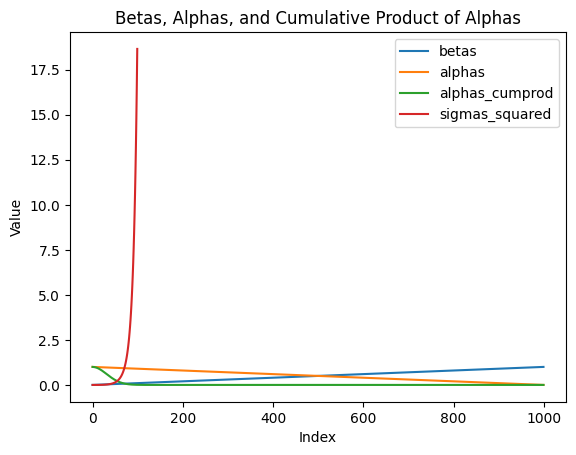

In [11]:
import torch

betas = torch.linspace(0, 1, 1000)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

import matplotlib.pyplot as plt
plt.plot(betas.numpy(), label='betas')
plt.plot(alphas.numpy(), label='alphas')
plt.plot(alphas_cumprod.numpy(), label='alphas_cumprod')
plt.plot(sigmas_squared[:100].numpy(), label='sigmas_squared')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Betas, Alphas, and Cumulative Product of Alphas')
plt.legend()
plt.show()


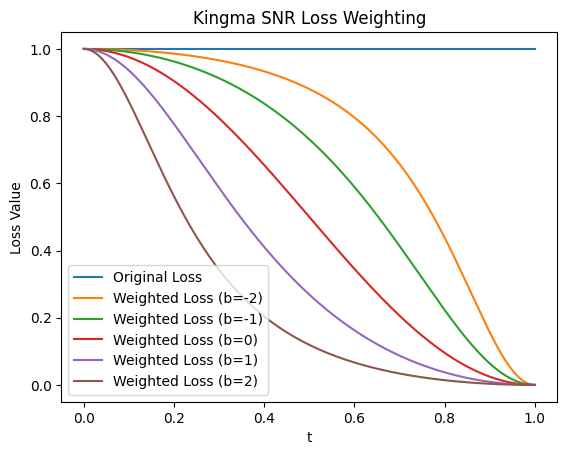

In [1]:
import torch
from distributional_diffusion_timeseries.models.diffusions.schedules import CosineSchedule

class KingmaSNRLossWeighting:
	"""Kingma et al. (2021) SNR loss weighting."""

	def __init__(self, b=0):
		self.b = b

	def __call__(self, loss, schedule_t):
		logsnr = schedule_t["log_snr"]
		weight = (1 + (self.b - logsnr).exp()) ** -1

		return loss * weight

t = torch.linspace(0, 1, 1000)
schedule = CosineSchedule()
schedule_t = schedule(t)

loss_weighting = [KingmaSNRLossWeighting(b=b) for b in [-2, -1, 0, 1, 2]]

losses = torch.ones_like(t)  # Example losses, can be any tensor
weighted_losses = [lw(losses, schedule_t) for lw in loss_weighting]

import matplotlib.pyplot as plt
plt.plot(t.numpy(), losses.numpy(), label='Original Loss')
for i, weighted_loss in enumerate(weighted_losses):
    plt.plot(t.numpy(), weighted_loss.numpy(), label=f'Weighted Loss (b={[-2, -1, 0, 1, 2][i]})')
plt.xlabel('t')
plt.ylabel('Loss Value')
plt.title('Kingma SNR Loss Weighting')
plt.legend()
plt.show()

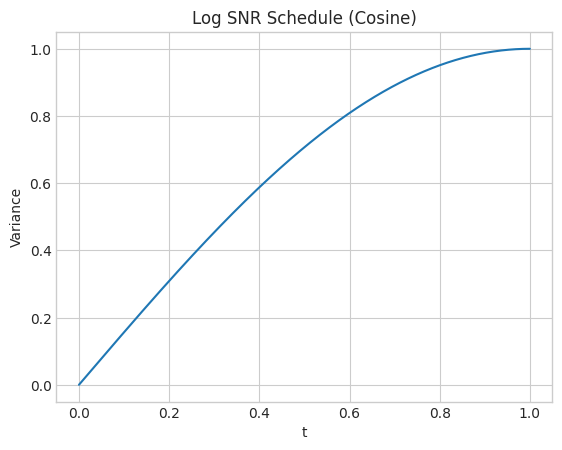

In [29]:
from typing import Callable, Optional
import math
from tqdm import tqdm
import torch
from torch.distributions import Normal

# Assuming these are available in your project structure
from distributional_diffusion_timeseries.models.utils import default, right_pad_dims_to
import distributional_diffusion_timeseries.datasets.image_loader as vl
from torchvision import transforms
from distributional_diffusion_timeseries.image_utils import tensor_to_gif_bytes
from distributional_diffusion_timeseries.models.diffusions.schedules import CosineSchedule
from IPython.display import display, Image as IPImage
import numpy as np
import torch
import matplotlib.pyplot as plt


t = torch.linspace(0, 1, 1000)
noise_schedule = CosineSchedule()

plt.plot(t.numpy(), noise_schedule(t)["sigma"].numpy())
plt.xlabel("t")
plt.ylabel("Variance")
plt.title("Log SNR Schedule (Cosine)")
plt.grid(True)
plt.show()


In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
from datasets import load_dataset
dataset_source = load_dataset("cifar10", trust_remote_code=False)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
dataset_source

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [23]:
import torch

x = torch.tensor([2., 2, 0, 0])
y = torch.tensor([0.1, 0.3, 0.000001, 1.2])
x_norm = torch.norm(x, p=2)
y_norm = torch.norm(y, p=2)

normalization_factor = x_norm * 0.5
interaction_term = torch.where(
    x_norm > 0, y * (normalization_factor / y_norm), y
)

print(x_norm)
print(interaction_term)
print(torch.norm(interaction_term, p=2))

tensor(2.8284)
tensor([1.1396e-01, 3.4188e-01, 1.1396e-06, 1.3675e+00])
tensor(1.4142)


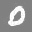

In [27]:
from PIL import Image

img = Image.open("/nfs/ghome/live/martorellat/dev/distributional_diffusion_timeseries/outputs/fid_images/image_distributional_diffusion_mnist_start_distributional_at_0/sample_00000.png")
img = img.convert("RGB")  # Convert to RGB if not already
img

In [51]:
import operator
import torch
import composer
from composer.utils import load_checkpoint
import hydra
import sys
import os
from collections import OrderedDict

base_dir = "/ceph/scratch/martorellat/trained_models"
config_dir = f"{base_dir}/new_image_SimpleDiffusion_cifar10"
# config_dir = f"{base_dir}/new_image_DistributionalDiffusion_cifar10_energy_kernel_stable_beta_1_lambda_1_KingmaSNRLossWeighting"
config_name = "resolved_config.yaml"

absolute_config_dir = os.path.abspath(config_dir)
if not os.path.isdir(absolute_config_dir):
	raise FileNotFoundError(f"Configuration directory not found at '{absolute_config_dir}'")

sys.path.append(os.path.dirname(absolute_config_dir))
with hydra.initialize_config_dir(config_dir=absolute_config_dir, job_name="generation_notebook"):
	config = hydra.compose(config_name=config_name)

model = hydra.utils.instantiate(config.model)

# Build list of algorithms.
algorithms = []
# Some algorithms should also be applied at inference time
if 'algorithms' in config:
	for ag_conf in config.algorithms:
		if '_target_' in ag_conf:
			print(f'Instantiating algorithm <{ag_conf._target_}>')
			algorithms.append(hydra.utils.instantiate(ag_conf))
		# elif ag_name == 'low_precision_groupnorm':
		# 	surgery_target = model
		# 	if 'attribute' in ag_conf:
		# 		surgery_target = operator.attrgetter(ag_conf.attribute)(model)
		# 	apply_low_precision_groupnorm(
		# 		model=surgery_target,
		# 		precision=Precision(ag_conf['precision']),
		# 		optimizers=None,
		# 	)
		# elif ag_name == 'low_precision_layernorm':
		# 	surgery_target = model
		# 	if 'attribute' in ag_conf:
		# 		surgery_target = operator.attrgetter(ag_conf.attribute)(model)
		# 	apply_low_precision_layernorm(
		# 		model=surgery_target,
		# 		precision=Precision(ag_conf['precision']),
		# 		optimizers=None,
		# 	)

local_checkpoint_path = f"{config_dir}/latest-rank0.pt"

state_dict = torch.load(local_checkpoint_path, map_location='cpu', weights_only=False)
for key in list(state_dict['state']['model'].keys()):
	if 'val_metrics.' in key:
		del state_dict['state']['model'][key]

ema_algo = [x for x in state_dict["state"]["algorithms"] if "EMA" in x]
ema_weights = ema_algo[0][1]["ema_model"] if ema_algo != [] else None
if ema_weights is not None:
    combined_state_dict = ema_weights["named_parameters_dict"]
    combined_state_dict.update(ema_weights.get('named_buffers_dict', {}))
    new_state_dict = OrderedDict(combined_state_dict)
    model.load_state_dict(new_state_dict, strict=True)
else:
	model.load_state_dict(state_dict['state']['model'], strict=True)
# model.load_state_dict(state_dict['state']['model'], strict=True)
model = model.eval()

# model = load_checkpoint(
#     ckp_path,
#     state,
#     logger
# )

/tmp/ipykernel_3487992/347217238.py:20: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=absolute_config_dir, job_name="generation_notebook"):


Instantiating algorithm <composer.algorithms.GradientClipping>
Instantiating algorithm <composer.algorithms.EMA>


In [2]:
from torchvision import transforms

generated_samples = model.generate(
    seed=42,
    sampling_steps=50,
    batch_size=4,
    context=None,
).to("cpu")

resize_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
    ]
    + ([transforms.Grayscale(num_output_channels=3)] if generated_samples.shape[1] == 1 else [])
)

for sample in generated_samples:
    resized_sample = resize_transform(sample)
    display(resized_sample)

NameError: name 'model' is not defined

Converting characteristic times for your Custom Cosine Schedule.
------------------------------------------------------------
Converting Speciation Time (t_S):
  - t_biroli = 1.4100 -> target logSNR = -2.7585
  - Calculated t_your = 0.8432

------------------------------------------------------------
Converting Collapse Time (t_C):
  - t_biroli = 0.6500 -> target logSNR = -0.9818
  - Calculated t_your = 0.6504

                       SUMMARY OF RESULTS
| Time         | Biroli Scale [0, ∞)       | Your Cosine Schedule [0, 1]    |
|--------------|---------------------------|--------------------------------|
| Speciation   | 1.4100                    | 0.8432                         |
| Collapse     | 0.6500                    | 0.6504                         |


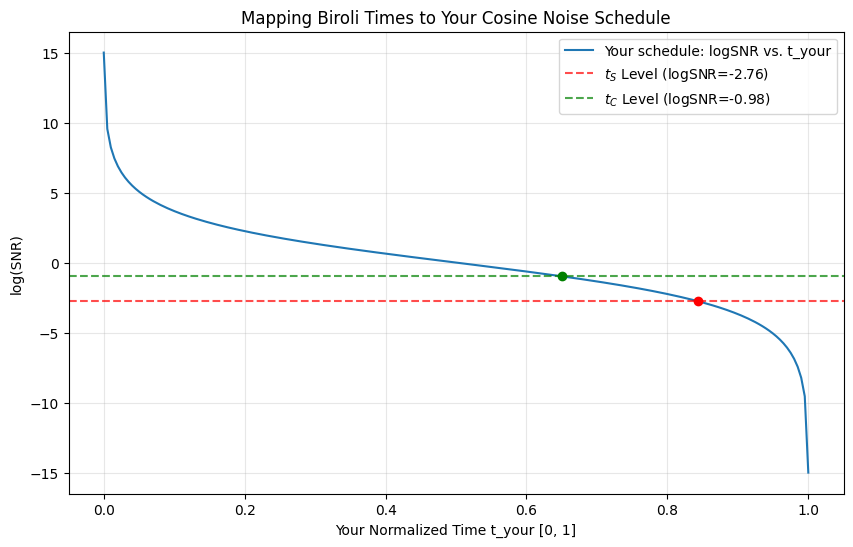

In [3]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

# Your provided CosineSchedule class
# I've modified it slightly to accept numpy arrays for plotting
class CosineSchedule:
    def __init__(self, logsnr_min=-15, logsnr_max=15):
        self.logsnr_min = logsnr_min
        self.logsnr_max = logsnr_max

        t_min = math.atan(math.exp(-0.5 * logsnr_max))
        t_max = math.atan(math.exp(-0.5 * logsnr_min))
        self.t_min = t_min
        self.t_max = t_max

    def __call__(self, t):
        # Allow both torch tensors and numpy arrays
        if isinstance(t, np.ndarray):
            log_fn = np.log
            tan_fn = np.tan
        else:
            log_fn = torch.log
            tan_fn = torch.tan
            
        logsnr = -2 * log_fn(tan_fn(self.t_min + t * (self.t_max - self.t_min)))
        return logsnr

# The conversion function using the analytical formula we derived
def convert_biroli_to_custom_cosine(t_biroli: float, schedule: CosineSchedule, eps: float = 1e-20) -> float:
    """
    Converts a time from the Biroli [0, inf) scale to your custom cosine schedule's [0, 1] scale.
    
    Args:
        t_biroli: The time to convert (e.g., t_S or t_C).
        schedule: An instance of your CosineSchedule class.
        eps: A small epsilon to prevent log(0).
        
    Returns:
        The equivalent time t_your on the [0, 1] scale.
    """
    # 1. Calculate the target logSNR that corresponds to the Biroli time.
    #    SNR_biroli = exp(-2*t) / (1 - exp(-2*t))
    #    logSNR_biroli = log(SNR_biroli)
    exp_m2t = np.exp(-2 * t_biroli)
    target_logSNR = np.log((exp_m2t + eps) / (1 - exp_m2t + eps))

    # 2. Invert the schedule's formula to find the t_your that gives this logSNR.
    #    t_your = (atan(exp(-0.5 * target_logSNR)) - t_min) / (t_max - t_min)
    exp_val = np.exp(-0.5 * target_logSNR)
    atan_val = np.arctan(exp_val)
    
    t_your = (atan_val - schedule.t_min) / (schedule.t_max - schedule.t_min)

    print(f"  - t_biroli = {t_biroli:.4f} -> target logSNR = {target_logSNR:.4f}")
    print(f"  - Calculated t_your = {t_your:.4f}")
    
    return t_your

# --- Main Demonstration ---

# 1. Instantiate your schedule
# These are the default values, you can change them if you use different ones.
custom_schedule = CosineSchedule(logsnr_min=-15, logsnr_max=15)

# 2. Let's use the same plausible example values
t_S_biroli = 1.41
t_C_biroli = 0.65

print(f"Converting characteristic times for your Custom Cosine Schedule.")
print("-" * 60)

print(f"Converting Speciation Time (t_S):")
t_S_your = convert_biroli_to_custom_cosine(t_S_biroli, custom_schedule)

print("\n" + "-" * 60)
print(f"Converting Collapse Time (t_C):")
t_C_your = convert_biroli_to_custom_cosine(t_C_biroli, custom_schedule)

print("\n" + "=" * 70)
print("                       SUMMARY OF RESULTS")
print("=" * 70)
print(f"| {'Time':<12} | {'Biroli Scale [0, ∞)':<25} | {'Your Cosine Schedule [0, 1]':<30} |")
print(f"|{'-'*14}|{'-'*27}|{'-'*32}|")
print(f"| {'Speciation':<12} | {t_S_biroli:<25.4f} | {t_S_your:<30.4f} |")
print(f"| {'Collapse':<12} | {t_C_biroli:<25.4f} | {t_C_your:<30.4f} |")
print("=" * 70)

# Optional: Plot the schedule to visualize the conversion
t_range_your = np.linspace(0.0, 1.0, 200)
logsnr_range = custom_schedule(t_range_your)

logsnr_S = np.log(np.exp(-2*t_S_biroli) / (1-np.exp(-2*t_S_biroli)))
logsnr_C = np.log(np.exp(-2*t_C_biroli) / (1-np.exp(-2*t_C_biroli)))

plt.figure(figsize=(10, 6))
plt.plot(t_range_your, logsnr_range, label='Your schedule: logSNR vs. t_your')
plt.scatter(t_S_your, logsnr_S, color='red', zorder=5)
plt.scatter(t_C_your, logsnr_C, color='green', zorder=5)
plt.axhline(y=logsnr_S, color='red', linestyle='--', alpha=0.7, label=f'$t_S$ Level (logSNR={logsnr_S:.2f})')
plt.axhline(y=logsnr_C, color='green', linestyle='--', alpha=0.7, label=f'$t_C$ Level (logSNR={logsnr_C:.2f})')

plt.xlabel("Your Normalized Time t_your [0, 1]")
plt.ylabel("log(SNR)")
plt.title("Mapping Biroli Times to Your Cosine Noise Schedule")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

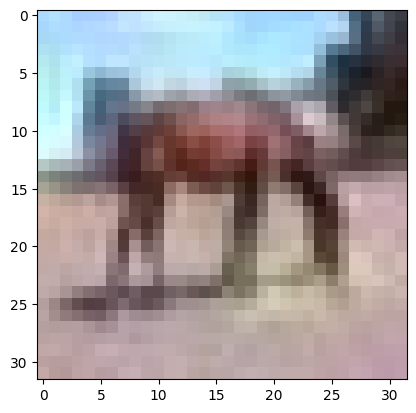

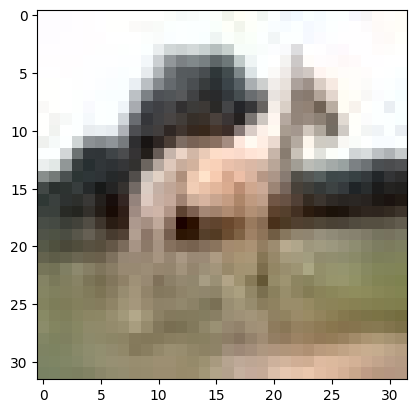

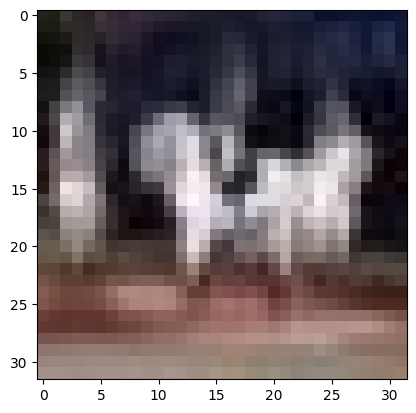

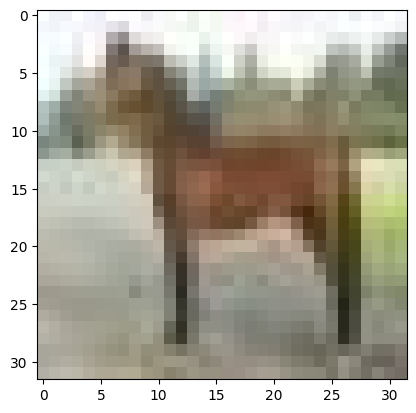

In [11]:
import distributional_diffusion_timeseries.datasets.image_loader as vl
from torchvision import transforms
from distributional_diffusion_timeseries.image_utils import tensor_to_gif_bytes
from IPython.display import display, Image as IPImage
import numpy as np
import torch
import matplotlib.pyplot as plt

dataloader = vl.build_streaming_image_dataloader(
	datadir="/ceph/scratch/martorellat/data/cifar10/mds/train",
	batch_size=32,
	shuffle=False,
	image_size=32,
	num_channels=3,
	transform=[transforms.ToTensor()],
)

j=0
for i in np.random.permutation(len(dataloader.dataset)):
	if dataloader.dataset.get_full_element_by_index(i)["label"] == 7:
		img = dataloader.dataset[i]
		plt.imshow(img["image"].numpy().transpose(1, 2, 0))
		plt.show()
		j+=1

	if j >= 4:
		break

# for i in np.random.permutation(len(dataloader.dataset))[:4]:
# 	generated_gif_bytes = tensor_to_gif_bytes(
# 		tensor=dataloader.dataset[i]["image"],  # Pass the tensor here
# 		duration_ms=100,
# 		data_range=(0.0, 1.0),
# 	)

# 	display(IPImage(data=generated_gif_bytes))  # Display the generated GIF


In [3]:
import torch

x = torch.tensor([1., 2., 3.])
print(torch.pow(x, 1/2))
print(torch.sqrt(x))

tensor([1.0000, 1.4142, 1.7321])
tensor([1.0000, 1.4142, 1.7321])


--- 1. Loading and Processing FID Metrics ---
✅ Loaded data for start_point: 0.0
✅ Loaded data for start_point: 0.05
✅ Loaded data for start_point: 0.1
✅ Loaded data for start_point: 0.2
✅ Loaded data for start_point: 0.3
✅ Loaded data for start_point: 0.4
ℹ️ Info: CSV file not found, skipping: /ceph/scratch/martorellat/trained_models/mnist_curriculum_beta_conf_2.0_to_1.0_beta_inter__1.0_step_start_distributional_at_0.50dur/fid_metrics.csv
ℹ️ Info: CSV file not found, skipping: /ceph/scratch/martorellat/trained_models/mnist_curriculum_beta_conf_2.0_to_1.0_beta_inter__1.0_step_start_distributional_at_0.60dur/fid_metrics.csv
ℹ️ Info: CSV file not found, skipping: /ceph/scratch/martorellat/trained_models/mnist_curriculum_beta_conf_2.0_to_1.0_beta_inter__1.0_step_start_distributional_at_0.70dur/fid_metrics.csv
ℹ️ Info: CSV file not found, skipping: /ceph/scratch/martorellat/trained_models/mnist_curriculum_beta_conf_2.0_to_1.0_beta_inter__1.0_step_start_distributional_at_0.80dur/fid_metrics

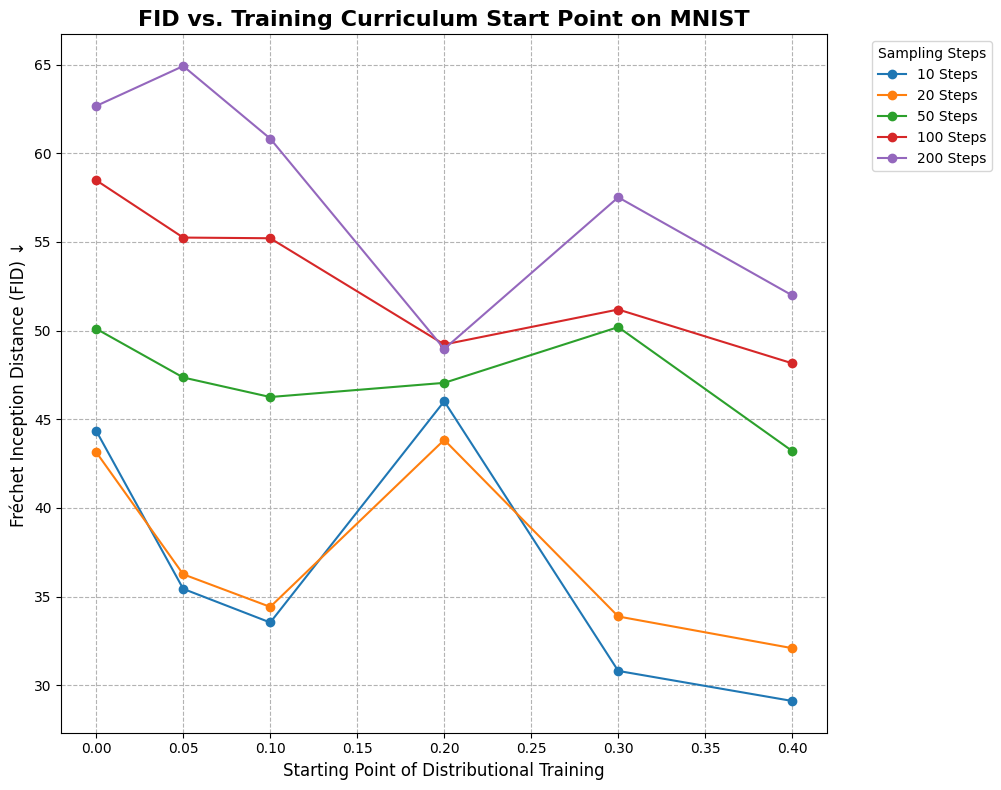


✅ Successfully saved plot to: /nfs/ghome/live/martorellat/dev/distributional_diffusion_timeseries/output/fid_curves/mnist/curriculum_beta_2_to_1/fid_vs_start_point.png


In [ ]:
# ruff: noqa

# %%
# ============== A SCRIPT TO PLOT FID vs. STARTING POINT ==============
#
# Instructions:
# 1. This script is designed to plot FID vs. the 'starting_point' parameter
#    from the experiment name. Each line on the plot will represent a fixed
#    number of sampling steps.
#
# 2. Make sure all required libraries are installed:
#    pip install pandas matplotlib
#
# 3. At the VERY BOTTOM of this script (in the __main__ block), set your
#    BASE_DIR and select which sampling steps you wish to display.
#
# 4. Run the script. The plot will be saved automatically.
#

# --- 1. IMPORTS ---
import os
import sys
import re
import itertools
from pathlib import Path

# Core data and plotting libraries
import pandas as pd
import matplotlib.pyplot as plt

# --- 2. HELPER FUNCTIONS ---

def get_names_from_experiment(experiment_name, dataset_name):
	"""
	Retrieves a list of configuration names and a corresponding subfolder
	for a given experiment and dataset.
	"""
	match experiment_name:
		case "curriculum_beta_2_to_1":
			return (
				[
					f"{dataset_name}_curriculum_beta_conf_2.0_to_1.0_beta_inter__1.0_step_start_distributional_at_{starting_point}dur"
					for starting_point in ["0.00", "0.05", "0.10", "0.20", "0.30", "0.40", "0.50", "0.60", "0.70", "0.80", "0.90", "1.0"]
				],
				f"{dataset_name}/curriculum_beta_2_to_1"
			)
	# Add other experiment cases here if needed
	return [], "unknown_experiment"

def extract_start_point(config_name: str) -> float:
    """Extracts the 'starting_point' value from the experiment name."""
    match = re.search(r"start_distributional_at_(\d+\.\d+)", config_name)
    if match:
        return float(match.group(1))
    # Return a value that indicates failure, which will cause the config to be skipped.
    return -1.0

# --- 3. MAIN PLOTTING WORKFLOW ---

def plot_fid_curves_by_start_point(
    config_names: list[str],
    base_dir: str,
    output_path: str,
    plot_title: str,
    steps_to_plot: list[int] | None = None,
):
    """
    Loads FID data and plots FID vs. start_point, with each line
    representing a specific number of sampling steps.
    """
    all_metrics = []
    print("--- 1. Loading and Processing FID Metrics ---")

    for name in config_names:
        csv_path = Path(base_dir) / name / "fid_metrics.csv"
        start_point = extract_start_point(name)

        if not csv_path.exists():
            # This is a common case (not all experiments may have run), so just inform the user.
            print(f"ℹ️ Info: CSV file not found, skipping: {csv_path}")
            continue

        if start_point < 0:
            print(f"⚠️ Warning: Could not extract start_point, skipping config: {name}")
            continue

        try:
            df = pd.read_csv(csv_path)
            df['start_point'] = start_point # Add the extracted start_point
            all_metrics.append(df)
            print(f"✅ Loaded data for start_point: {start_point}")
        except Exception as e:
            print(f"❌ Error reading {csv_path}: {e}")

    if not all_metrics:
        print("\n--- No data was loaded. Cannot generate plot. ---")
        return

    combined_df = pd.concat(all_metrics, ignore_index=True)

    # Filter for specific steps if requested, for plot clarity
    if steps_to_plot:
        plot_df = combined_df[combined_df['Sampling Steps'].isin(steps_to_plot)]
    else:
        plot_df = combined_df
    
    unique_steps = sorted(plot_df['Sampling Steps'].unique())

    if not unique_steps:
        print(f"\n--- No data found for the selected steps: {steps_to_plot}. Cannot generate plot. ---")
        return

    print(f"\n--- 2. Generating Plot for steps: {unique_steps} ---")

    # --- Plotting with Matplotlib ---
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12, 8))

    # Loop through each number of steps to plot its line
    for step in unique_steps:
        # Filter data for the current step and sort by start_point to ensure the line connects correctly
        step_df = plot_df[plot_df['Sampling Steps'] == step].sort_values('start_point')
        ax.plot(
            step_df["start_point"],
            step_df["FID"],
            marker="o",
            linestyle="-",
            label=f"{step} Steps"
        )

    # --- Customization ---
    ax.set_title(plot_title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Starting Point of Distributional Training", fontsize=12)
    ax.set_ylabel("Fréchet Inception Distance (FID) ↓", fontsize=12)
    ax.grid(True, which="both", ls="--", c='0.7')
    ax.legend(
        title="Sampling Steps",
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # --- Saving the Plot ---
    output_file = Path(output_path)
    output_file.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"\n✅ Successfully saved plot to: {output_file.resolve()}")


# %%
# --- 4. EXECUTION ---
if __name__ == "__main__":
    # ============================ ACTION REQUIRED =======================================
    # Set the base directory where your experiment folders are located.
    BASE_DIR = "/ceph/scratch/martorellat/trained_models"

    # Define the experiment set to plot.
    EXPERIMENT_NAME = "curriculum_beta_2_to_1"
    DATASET_NAME = "mnist"

    # Select which sampling steps to show on the plot for clarity.
    # An empty list [] will plot all available steps.
    STEPS_TO_PLOT = [10, 20, 50, 100, 200]
    # ====================================================================================

    try:
        # Get the list of experiment directory names and the output subfolder
        CONFIG_NAMES, output_subfolder = get_names_from_experiment(EXPERIMENT_NAME, DATASET_NAME)
        
        if not CONFIG_NAMES:
            raise ValueError(f"No configurations defined for experiment '{EXPERIMENT_NAME}' on dataset '{DATASET_NAME}'.")

        # Define the output path and title for the plot
        output_plot_path = f"output/fid_curves/{output_subfolder}/fid_vs_start_point.png"
        plot_title = f"FID vs. Training Curriculum Start Point on {DATASET_NAME.upper()}"

        # Call the main plotting function
        plot_fid_curves_by_start_point(
            config_names=CONFIG_NAMES,
            base_dir=BASE_DIR,
            output_path=output_plot_path,
            plot_title=plot_title,
            steps_to_plot=STEPS_TO_PLOT
        )

    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}", file=sys.stderr)
        import traceback
        traceback.print_exc()


In [4]:
import numpy as np
from PIL import Image, ImageDraw
import imageio
from skimage.measure import regionprops, label
import math

# --- Configuration Constants ---
CANVAS_SIZE = (96, 96)
BOX_SIZE = (28, 28)
# The white box is centered, so we can calculate its boundaries
BOX_TOP_LEFT = (
    (CANVAS_SIZE[0] - BOX_SIZE[0]) // 2, # x-coordinate
    (CANVAS_SIZE[1] - BOX_SIZE[1]) // 2  # y-coordinate
)
BOX_BOTTOM_RIGHT = (
    BOX_TOP_LEFT[0] + BOX_SIZE[0],
    BOX_TOP_LEFT[1] + BOX_SIZE[1]
)


def find_digit_centroid(frame_array: np.ndarray) -> tuple[float, float] | None:
    """
    Finds the centroid of the digit in a single frame.

    Args:
        frame_array: A NumPy array representing the GIF frame.

    Returns:
        A tuple (x, y) of the digit's centroid, or None if no digit is found.
    """
    # Create a mutable copy of the frame
    processed_frame = frame_array.copy()

    # Erase the central white box by setting its pixels to black (0)
    # This isolates the digit as the only non-black object.
    processed_frame[BOX_TOP_LEFT[1]:BOX_BOTTOM_RIGHT[1], BOX_TOP_LEFT[0]:BOX_BOTTOM_RIGHT[0]] = 0

    # Binarize the image to ensure clean object detection (anything not black is the digit)
    binary_image = processed_frame > 20  # Threshold to handle any anti-aliasing

    # Use scikit-image's regionprops to find properties of connected components (our digit)
    labeled_image = label(binary_image)
    regions = regionprops(labeled_image)

    if not regions:
        return None

    # Assuming the largest non-box object is our digit
    digit_region = max(regions, key=lambda r: r.area)
    # centroid property returns (row, col) which corresponds to (y, x)
    y, x = digit_region.centroid
    
    return x, y

def get_direction_vector(points: list[tuple[float, float]]) -> np.ndarray:
    """
    Calculates the direction vector from a sequence of points using linear regression.
    This is robust to noise/wiggling.
    
    Args:
        points: A list of (x, y) coordinates.

    Returns:
        A NumPy array representing the direction vector (vx, vy).
    """
    # We model position as P(t) = P0 + v*t. We want to find the velocity vector v.
    # We can do this by fitting x(t) and y(t) independently.
    points_arr = np.array(points)
    num_points = len(points)
    
    # Time steps are simply 0, 1, 2, ...
    t = np.arange(num_points)

    # Fit a 1st degree polynomial (a line) to x vs t and y vs t
    # The slope of the line is the velocity component.
    # polyfit returns [slope, intercept]
    vx = np.polyfit(t, points_arr[:, 0], 1)[0]
    vy = np.polyfit(t, points_arr[:, 1], 1)[0]
    
    return np.array([vx, vy])

def analyze_gif_movement(gif_path: str) -> dict:
    """
    Analyzes a GIF to extract digit motion vectors and the relative angle.

    Args:
        gif_path: The file path to the 8-frame GIF.

    Returns:
        A dictionary containing the two direction vectors and the angle in degrees.
    """
    try:
        gif = Image.open(gif_path)
    except FileNotFoundError:
        print(f"Error: File not found at {gif_path}")
        return None

    centroids = []
    num_frames = 0
    for frame_index in range(gif.n_frames):
        gif.seek(frame_index)
        # Convert to grayscale ('L') and then to a NumPy array
        frame_array = np.array(gif.convert('L'))
        centroid = find_digit_centroid(frame_array)
        centroids.append(centroid)
        num_frames += 1

    if num_frames != 8:
        print(f"Warning: Expected 8 frames, but found {num_frames}. Analysis may be incorrect.")

    # Part 1: Frames 1-4 (indices 0-3)
    points_part1 = [c for c in centroids[0:4] if c is not None]
    if len(points_part1) < 2:
        raise ValueError("Could not find the digit in at least two frames of the first half.")
    
    # Part 2: Frames 6-8 (indices 5-7)
    points_part2 = [c for c in centroids[5:8] if c is not None]
    if len(points_part2) < 2:
        raise ValueError("Could not find the digit in at least two frames of the second half.")
        
    # Calculate direction vectors using our robust method
    dir1 = get_direction_vector(points_part1)
    dir2 = get_direction_vector(points_part2)
    
    # Calculate the relative angle between the two direction vectors
    # Angle formula: arccos((v1 . v2) / (||v1|| * ||v2||))
    unit_dir1 = dir1 / np.linalg.norm(dir1)
    unit_dir2 = dir2 / np.linalg.norm(dir2)
    
    dot_product = np.dot(unit_dir1, unit_dir2)
    # Clip to avoid floating point errors with arccos
    dot_product = np.clip(dot_product, -1.0, 1.0)
    
    angle_rad = np.arccos(dot_product)
    angle_deg = np.degrees(angle_rad)
    
    return {
        "direction_vector_1": dir1,
        "direction_vector_2": dir2,
        "relative_angle_degrees": angle_deg
    }

def create_test_gif(filename="test_motion.gif", dir1_angle_deg=225, dir2_angle_deg=30, wiggle=2.0):
    """
    Generates a test GIF according to the specified movement rules.
    """
    print(f"Creating test GIF '{filename}'...")
    frames = []
    
    # --- Calculate trajectories ---
    center = np.array([CANVAS_SIZE[0] / 2, CANVAS_SIZE[1] / 2])
    radius = CANVAS_SIZE[0] / 2
    
    # Part 1: From border to center
    rad1 = np.radians(dir1_angle_deg)
    vec1 = np.array([np.cos(rad1), np.sin(rad1)])
    start_pos1 = center + vec1 * radius
    end_pos1 = center + vec1 * 15 # End just inside the box
    positions1 = np.linspace(start_pos1, end_pos1, 4)

    # Part 2: From center to border
    rad2 = np.radians(dir2_angle_deg)
    vec2 = np.array([np.cos(rad2), np.sin(rad2)])
    start_pos2 = center + vec2 * 15 # Start just outside the box
    end_pos2 = center + vec2 * radius
    positions2 = np.linspace(start_pos2, end_pos2, 3)
    
    # Add wiggle to part 2
    positions2 += np.random.rand(*positions2.shape) * wiggle
    
    all_positions = list(positions1) + [None] + list(positions2)

    for pos in all_positions:
        # Create a black canvas and a drawable surface
        img = Image.new('L', CANVAS_SIZE, 0)
        draw = ImageDraw.Draw(img)
        
        # Draw the central white box
        draw.rectangle(
            (BOX_TOP_LEFT, BOX_BOTTOM_RIGHT),
            fill=255
        )
        
        # Draw the digit if it's visible in this frame
        if pos is not None:
            # Draw a simple '3' as our digit
            digit_pos = (pos[0] - 8, pos[1] - 8) # Center the digit text
            draw.text(digit_pos, "3", fill=255, font_size=28)
            
        frames.append(np.array(img))
        
    imageio.mimsave(filename, frames, fps=3)
    print("Test GIF created.")


if __name__ == "__main__":
    # 1. Define the parameters for our test GIF
    INCOMING_ANGLE = 135 # Degrees, from top-right
    OUTGOING_ANGLE = 300 # Degrees, to bottom-right
    # The relative angle should be |135 - 300| = 165 degrees
    
    # 2. Create the test GIF
    TEST_GIF_PATH = "test_digit_motion.gif"
    create_test_gif(
        filename=TEST_GIF_PATH, 
        dir1_angle_deg=INCOMING_ANGLE, 
        dir2_angle_deg=OUTGOING_ANGLE,
        wiggle=2.5 # Add some noise to the second half
    )
    
    # 3. Analyze the created GIF
    analysis_results = analyze_gif_movement(TEST_GIF_PATH)
    
    # 4. Print the results
    if analysis_results:
        print("\n--- Motion Analysis Results ---")
        np.set_printoptions(precision=3, suppress=True)
        print(f"Direction Vector 1 (Frames 1-4): {analysis_results['direction_vector_1']}")
        print(f"Direction Vector 2 (Frames 6-8): {analysis_results['direction_vector_2']}")
        print(f"Relative Angle: {analysis_results['relative_angle_degrees']:.2f} degrees")
        print("-----------------------------")
        print(f"\nExpected relative angle was approximately |{INCOMING_ANGLE} - {OUTGOING_ANGLE}| = {abs(INCOMING_ANGLE - OUTGOING_ANGLE)} degrees.")
        print("The result should be close to this value.")

Creating test GIF 'test_digit_motion.gif'...
Test GIF created.

--- Motion Analysis Results ---
Direction Vector 1 (Frames 1-4): [ 9.231 -7.579]
Direction Vector 2 (Frames 6-8): [ 12.632 -21.458]
Relative Angle: 20.13 degrees
-----------------------------

Expected relative angle was approximately |135 - 300| = 165 degrees.
The result should be close to this value.


In [32]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("google/ddpm-cifar10-32")

# image = pipe().images[0]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /nfs/ghome/live/martorellat/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /nfs/ghome/live/martorellat/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [33]:
# Calculate the number of parameters in the UNet model
def count_parameters(model):
	return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"UNet parameters: {count_parameters(pipe.unet):,}")

UNet parameters: 35,746,307


In [34]:
pipe.unet

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(12

In [6]:

# --- 1. IMPORTS ---
import itertools
import os
import sys
from typing import Optional, OrderedDict, List, Union, Dict
from io import BytesIO

# Core libraries
import torch
from torch import Tensor
import numpy as np
from PIL import Image as PILImage, ImageDraw, ImageFont
import imageio

# Hydra and Composer for configuration and reproducibility
import hydra
from omegaconf import OmegaConf, DictConfig
from composer.utils import reproducibility

# Visualization
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from IPython.display import display, Image as IPImage

# Assuming these are in your project structure
from distributional_diffusion_timeseries.models.diffusions.base_diffusion import Diffusion
from distributional_diffusion_timeseries.models.utils import normalize_to_neg_one_to_one

# --- 2. HELPER FUNCTIONS ---

def load_model_from_composer_checkpoint(model: torch.nn.Module, checkpoint_path: str, load_ema=True) -> torch.nn.Module:
	state_dict = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
	for key in list(state_dict["state"]["model"].keys()):
		if "val_metrics." in key:
			del state_dict["state"]["model"][key]

	ema_algo = [x for x in state_dict["state"]["algorithms"] if "EMA" in x]
	ema_weights = ema_algo[0][1]["ema_model"] if ema_algo != [] else None
	if ema_weights is not None and load_ema:
		combined_state_dict = ema_weights["named_parameters_dict"]
		combined_state_dict.update(ema_weights.get("named_buffers_dict", {}))
		new_state_dict = OrderedDict(combined_state_dict)
		model.load_state_dict(new_state_dict, strict=True)
	else:
		model.load_state_dict(state_dict["state"]["model"], strict=True)
	# model.load_state_dict(state_dict['state']['model'], strict=True)
	model = model.eval()
	return model

def count_parameters(model):
	return sum(p.numel() for p in model.parameters() if p.requires_grad)

absolute_config_dir = "/ceph/scratch/martorellat/trained_models/"
experiment = "new_image_SimpleDiffusion_cifar10"
absolute_config_dir = os.path.join(absolute_config_dir, experiment)
config_name = "resolved_config.yaml"

with hydra.initialize_config_dir(config_dir=absolute_config_dir, job_name="generation_notebook"):
    cfg = hydra.compose(config_name=config_name)

    print("\n--- 1. Configuration Loaded ---")
    experiment_name = cfg.get("exp_name", "Untitled Experiment")
    print(f"Experiment: {experiment_name}")

    print("\n--- 2. Instantiating and Loading Model ---")
    reproducibility.seed_all(cfg.seed)
    model = hydra.utils.instantiate(cfg.model)
    # Build list of algorithms.
    algorithms = []
    # Some algorithms should also be applied at inference time
    if "algorithms" in cfg:
        for ag_conf in cfg.algorithms:
            if "_target_" in ag_conf:
                print(f"Instantiating algorithm <{ag_conf._target_}>")
                algorithms.append(hydra.utils.instantiate(ag_conf))
    # checkpoint_path = os.path.join(cfg.trainer.save_folder, "latest-rank0.pt")
    # model: Diffusion = load_model_from_composer_checkpoint(
    #     model=model, checkpoint_path=checkpoint_path, load_ema=True
    # )
    print("✅ Model is ready for generation!")
    print(f"Model UNet parameters: {count_parameters(model):,}")

/tmp/ipykernel_1833582/190879230.py:59: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=absolute_config_dir, job_name="generation_notebook"):



--- 1. Configuration Loaded ---
Experiment: new_image_SimpleDiffusion_cifar10

--- 2. Instantiating and Loading Model ---
Instantiating algorithm <composer.algorithms.GradientClipping>
Instantiating algorithm <composer.algorithms.EMA>
✅ Model is ready for generation!
Model UNet parameters: 32,352,523


In [7]:
model

SimpleDiffusion(
  (network): UViT(
    (init_conv): Conv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): LearnedSinusoidalPosEmb()
      (1): Linear(in_features=17, out_features=512, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (input_norm): RMSNorm()
          (skip_norm): RMSNorm()
          (mlp): Linear(in_features=512, out_features=256, bias=True)
          (block1): Block(
            (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): RMSNorm()
            (act): GELU(approximate='none')
          )
          (block2): Block(
            (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): RMSNorm()
            (act): GELU(approximate='none')
          )
        )
        (2): Seque

In [5]:
from distributional_diffusion_timeseries.models.architectures.uvit import UViT

def UViT_S(
	image_size=32,
	image_channels=3,
	dim=128,
	input_channel_multiplier=2,
	attn_dim_head=64,
	dim_mults=(1, 2, 2),
	downsample_factor=2,
	**kwargs,
):
	return UViT(
		image_size=image_size,
		dim=dim,
		channels=image_channels,
		input_channel_multiplier=input_channel_multiplier,
		downsample_factor=downsample_factor,
		vit_depth=10,
		dim_mults=dim_mults,
		attn_dim_head=attn_dim_head,
		attn_heads=8,
		ff_mult=4,
		learned_sinusoidal_dim=40,
		**kwargs,
	)

model2 = UViT_S()

# Calculate the number of parameters in the UNet model
def count_parameters(model):
	return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"UViT parameters: {count_parameters(model2):,}")

Downsampled to: 16x16 at resolution 1
Downsampled to: 8x8 at resolution 2
Downsampled to: 4x4 at resolution 3
UViT parameters: 33,957,402


In [ ]:
UViT parameters: 55,454,478

In [1]:
import glob
import os
import pandas as pd

def get_display_name_from_exp_name(exp_name: str) -> str:
    """
    Extracts a human-readable display name from the experiment name.
    """
    # Example: "cifar10_cond_openai" -> "CIFAR-10 Conditional OpenAI"
    parts = exp_name.split('_')
    new_parts = []
    for i in range(len(parts)):
        words_to_skip = ["cifar10", "samples", "final"]
        for w in words_to_skip:
            if w in parts[i].lower():
                break
        else:
            # Capitalize the first letter of each part and handle special cases
            if parts[i].lower().startswith("aaa"):
                parts[i] = parts[i][3:].capitalize()  # Skip "aaa" prefix
            
            if parts[i] == "cond":
                parts[i] = "Conditional"
            elif parts[i] == "dynamical":
                parts[i] = "Dynamical Regimes"
            else:
                parts[i] = parts[i].capitalize()
            new_parts.append(parts[i])
    return ' '.join(part for part in new_parts)


base_dir = "/ceph/scratch/martorellat/guided_diffusion/"
result_files = glob.glob(os.path.join(base_dir, "improvements/**/results.csv"), recursive=True)
result_files += glob.glob(os.path.join(base_dir, "curriculum/**/results.csv"), recursive=True)
result_files += [
    # f"{base_dir}/curriculum/samples_FINAL3_curriculum_start_at_00percent/results.csv",
    f"{base_dir}/samples_cifar10_cond_openai/results.csv"
]

cumulative_df = pd.DataFrame()

for samples_dir in result_files:
    exp_name = samples_dir.split("/")[-2]  # Extract experiment name from directory path
    print(f"Processing samples directory: {samples_dir} for experiment: {exp_name}")
    csv_path = samples_dir
    # Load and filter CSV data
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        
        # Filter data based on provided parameters
        filtered_df = df[
            (df['steps'].isin([5, 10, 20, 30, 50])) &
            # (df['cfg'].isin(args.cfg_scales)) &
            (df['sampling'].isin(["DDIM", "iDDPM", "DDIM_diff_noise", "iDDPM_diff_noise"])) &
            (df['num_samples'] == 50000)  # Assuming 50000 samples for FID
        ]

        # Take last timestamped row for each configuration
        filtered_df = filtered_df.sort_values('timestamp').drop_duplicates(
            subset=['steps', 'sampling'], keep='last'
        )

        # discard entries with a timestamp before 11th August 2025 at 20:25:00 UTC
        filtered_df = filtered_df[filtered_df['timestamp'] >= '2025-08-11T20:25:00']
        
        # Append to cumulative DataFrame
        filtered_df['full_exp_name'] = exp_name
        filtered_df['exp_name'] = get_display_name_from_exp_name(exp_name)
        cumulative_df = pd.concat([cumulative_df, filtered_df], ignore_index=True)
    else:
        print(f"CSV file not found: {csv_path}")

Processing samples directory: /ceph/scratch/martorellat/guided_diffusion/improvements/samples_FINAL_distributional_lambda_linear/results.csv for experiment: samples_FINAL_distributional_lambda_linear
Processing samples directory: /ceph/scratch/martorellat/guided_diffusion/improvements/samples_AAAdistributional_lambda_sigmoid/results.csv for experiment: samples_AAAdistributional_lambda_sigmoid
Processing samples directory: /ceph/scratch/martorellat/guided_diffusion/improvements/samples_AAAdistributional_lambda_dynamical_cosine/results.csv for experiment: samples_AAAdistributional_lambda_dynamical_cosine
Processing samples directory: /ceph/scratch/martorellat/guided_diffusion/improvements/samples_distributional_lambda_linear/results.csv for experiment: samples_distributional_lambda_linear
Processing samples directory: /ceph/scratch/martorellat/guided_diffusion/improvements/samples_FINAL_distributional_lambda_step/results.csv for experiment: samples_FINAL_distributional_lambda_step
Proces

In [2]:
# cumulative_df[cumulative_df["steps"] == 100].sort_values("fid")

for i in [5, 10, 20, 30, 50]:
    # print name of best fid
    # best_fid_df = cumulative_df[(cumulative_df["steps"] == i) & (cumulative_df["sampling"] == "DDIM_diff_noise")].sort_values("fid")
    best_fid_df = cumulative_df[(cumulative_df["steps"] == i)].sort_values("fid")
    if best_fid_df.empty:
        print(f"No data available for {i} steps.")
        continue
    best_fid_row = best_fid_df.iloc[0]
    print(f"Best FID for {i:3d} steps: - FID={best_fid_row['fid']:5.2f}, SAMPLING={best_fid_row['sampling']:16s}, {best_fid_row['exp_name']}")

# cumulative_df[cumulative_df["steps"] == 5].sort_values("inception_score", ascending=False)

Best FID for   5 steps: - FID=13.93, SAMPLING=DDIM_diff_noise , Curriculum Start At 15percent
Best FID for  10 steps: - FID= 4.55, SAMPLING=iDDPM_diff_noise, Curriculum Start At 00percent
Best FID for  20 steps: - FID= 5.16, SAMPLING=iDDPM_diff_noise, Distributional Lambda Dynamical Regimes Step
Best FID for  30 steps: - FID= 5.36, SAMPLING=iDDPM_diff_noise, Distributional Lambda Dynamical Regimes Step
Best FID for  50 steps: - FID= 4.69, SAMPLING=DDIM            , Curriculum Baseline


In [7]:
from IPython.display import display
display(cumulative_df[cumulative_df["exp_name"] == "Curriculum Start At 15percent"].sort_values(["steps", "fid"], ascending=True))
# display(cumulative_df[cumulative_df["exp_name"] == "Curriculum Start At 20percent"].sort_values(["steps", "fid"], ascending=True))
# display(cumulative_df[(cumulative_df["steps"] == 10) & (cumulative_df["sampling"].isin(["DDIM_diff_noise"]))].sort_values("fid", ascending=True).drop_duplicates(subset=['exp_name'], keep='first'))

,steps,sampling,num_samples,inception_score,fid,sfid,precision,recall,timestamp,full_exp_name,exp_name
582,5,DDIM_diff_noise,50000,10.118338,13.928123,13.979366,0.55630,0.48470,2025-08-13T14:00:10,samples_curriculum_start_at_15percent,Curriculum Start At 15percent
580,5,DDIM,50000,9.917226,17.238915,20.118216,0.54640,0.46354,2025-08-13T13:54:09,samples_curriculum_start_at_15percent,Curriculum Start At 15percent
581,5,iDDPM,50000,9.120707,37.189891,24.692685,0.47310,0.59406,2025-08-13T13:57:08,samples_curriculum_start_at_15percent,Curriculum Start At 15percent
583,5,iDDPM_diff_noise,50000,8.781703,40.902694,21.568313,0.45908,0.58044,2025-08-13T14:03:12,samples_curriculum_start_at_15percent,Curriculum Start At 15percent
586,10,DDIM_diff_noise,50000,10.453290,7.151763,6.664535,0.64946,0.55562,2025-08-13T14:15:47,samples_curriculum_start_at_15percent,Curriculum Start At 15percent
587,10,iDDPM_diff_noise,50000,10.141186,9.781409,7.200081,0.59390,0.61244,2025-08-13T14:19:57,samples_curriculum_start_at_15percent,Curriculum Start At 15percent
585,10,iDDPM,50000,10.315536,10.751654,14.401016,0.58478,0.58182,2025-08-13T14:11:37,samples_curriculum_start_at_15percent,Curriculum Start At 15percent
584,10,DDIM,50000,10.225200,12.119524,19.075907,0.58608,0.51826,2025-08-13T14:07:27,samples_curriculum_start_at_15percent,Curriculum Start At 15percent
590,20,DDIM_diff_noise,50000,10.308591,6.633507,5.427081,0.66574,0.57256,2025-08-13T14:39:25,samples_curriculum_start_at_15percent,Curriculum Start At 15percent
591,20,iDDPM_diff_noise,50000,10.155370,7.661070,5.756007,0.64924,0.58300,2025-08-13T14:45:53,samples_curriculum_start_at_15percent,Curriculum Start At 15percent


In [5]:
fid_entries_needed = 4 * 5  # 4 algorithms, 5 steps
total_experiments = (
    12 # curriculums
    + 1 # baseline openai
    + 12 # improvements lambda schedule
    + 12 # improvements beta schedule
    + 2 # dispersion
)
aaa = cumulative_df[cumulative_df["steps"] < 100].groupby(["exp_name"])["fid"].count()
print(f"{(aaa == fid_entries_needed).sum()} out of {total_experiments} experiments have {fid_entries_needed} FID entries.\n")
print("COMPLETED EXPERIMENTS:")
display(aaa[aaa == fid_entries_needed].sort_index())
print("EXPERIMENTS WITH MISSING FID ENTRIES:")
display(aaa[aaa < fid_entries_needed].sort_index())

31 out of 39 experiments have 20 FID entries.

COMPLETED EXPERIMENTS:


exp_name
Curriculum Baseline                                             20
Curriculum Start At 00percent                                   20
Curriculum Start At 10percent                                   20
Curriculum Start At 20percent                                   20
Curriculum Start At 30percent                                   20
Curriculum Start At 40percent                                   20
Curriculum Start At 50percent                                   20
Curriculum Start At 60percent                                   20
Curriculum Start At 70percent                                   20
Curriculum Start At 80percent                                   20
Curriculum Start At 90percent                                   20
Distributional Lambda Beta Cosine                               20
Distributional Lambda Beta Dynamical Regimes Cosine             20
Distributional Lambda Beta Dynamical Regimes Linear             20
Distributional Lambda Beta Dynamical Regimes Sigmoid 

EXPERIMENTS WITH MISSING FID ENTRIES:


exp_name
Conditional Openai                                         10
Curriculum Start At 15percent                              18
Distributional Lambda Dynamical Regimes Sigmoid Shifted    10
Distributional Lambda Dynamical Regimes Step               10
Name: fid, dtype: int64

In [8]:
import numpy as np
import math

def get_iddpm_alphas_cumprod(num_diffusion_timesteps: int, s: float = 0.008):
    """
    Generates the exact alphas_cumprod schedule used in iDDPM.

    Args:
        num_diffusion_timesteps (int): The total number of steps (T).
        s (float): The small offset to prevent singularities near t=0.

    Returns:
        np.ndarray: The array of alphas_cumprod values.
    """
    def f(t_norm):
        return math.cos(((t_norm + s) / (1 + s)) * (math.pi / 2)) ** 2

    # Array of discrete times, from 0 to T (inclusive)
    t_steps = np.linspace(0, 1, num_diffusion_timesteps + 1)
    
    alphas_cumprod = np.zeros_like(t_steps)
    for i, t_norm in enumerate(t_steps):
        alphas_cumprod[i] = f(t_norm) / f(0)
    
    # We typically work with timesteps 0 to T-1, so we take the first T values
    return alphas_cumprod[:num_diffusion_timesteps]


def convert_biroli_to_iddpm(t_biroli: float, num_diffusion_timesteps: int, s: float = 0.008, eps: float = 1e-20) -> float:
    """
    Converts a time from the Biroli [0, inf) scale to the iDDPM cosine schedule's normalized [0, 1] scale.

    Args:
        t_biroli (float): The time to convert (e.g., your t_c).
        num_diffusion_timesteps (int): The total number of steps (T) in your iDDPM model.
        s (float): The offset hyperparameter from the iDDPM schedule.
        eps (float): A small epsilon for numerical stability.

    Returns:
        float: The equivalent time t_my_schedule on the normalized [0, 1] scale.
    """
    # --- STEP 1: Calculate the target logSNR from the Biroli time ---
    exp_m2t = np.exp(-2 * t_biroli)
    target_logSNR = np.log((exp_m2t + eps) / (1 - exp_m2t + eps))

    # --- STEP 2: Generate the logSNR schedule for the iDDPM model ---
    alphas_cumprod = get_iddpm_alphas_cumprod(num_diffusion_timesteps, s)
    logsnr_schedule = np.log((alphas_cumprod + eps) / (1 - alphas_cumprod + eps))
    
    # --- STEP 3: Find the closest discrete timestep and normalize ---
    # Find the index 'i' in the schedule whose logSNR value is closest to our target
    closest_discrete_step = np.argmin(np.abs(logsnr_schedule - target_logSNR))
    
    # Convert the integer index to a normalized time in [0, 1]
    t_my_schedule = closest_discrete_step / num_diffusion_timesteps

    print(f"--- Conversion Details ---")
    print(f"Biroli Time (t_c): {t_biroli:.4f}")
    print(f"Target logSNR: {target_logSNR:.4f}")
    print(f"Closest discrete step in your schedule: {closest_discrete_step} / {num_diffusion_timesteps}")
    print(f"logSNR at this step: {logsnr_schedule[closest_discrete_step]:.4f}")
    print(f"Converted Normalized Time (t_my_schedule): {t_my_schedule:.4f}")
    
    return t_my_schedule

# --- EXAMPLE USAGE ---

# Suppose you calculated your collapse time on the Biroli scale to be:
t_s_biroli = 2.0069
t_c_biroli = 0.470
t_sep_biroli = 0.015

# And your iDDPM model has 4000 total timesteps:
T = 4000

# Convert t_c to your model's [0, 1] time scale
t_s_my_schedule = convert_biroli_to_iddpm(t_s_biroli, num_diffusion_timesteps=T)
t_c_my_schedule = convert_biroli_to_iddpm(t_c_biroli, num_diffusion_timesteps=T)
t_sep_my_schedule = convert_biroli_to_iddpm(t_sep_biroli, num_diffusion_timesteps=T)

print(f"\nFinal Result: The Biroli time t_c = {t_s_biroli} corresponds to t_my_schedule = {t_s_my_schedule:.4f} in your iDDPM implementation.")
print(f"\nFinal Result: The Biroli time t_c = {t_c_biroli} corresponds to t_my_schedule = {t_c_my_schedule:.4f} in your iDDPM implementation.")
print(f"\nFinal Result: The Biroli time t_c = {t_sep_biroli} corresponds to t_my_schedule = {t_sep_my_schedule:.4f} in your iDDPM implementation.")

--- Conversion Details ---
Biroli Time (t_c): 2.0069
Target logSNR: -3.9956
Closest discrete step in your schedule: 3654 / 4000
logSNR at this step: -3.9957
Converted Normalized Time (t_my_schedule): 0.9135
--- Conversion Details ---
Biroli Time (t_c): 0.4700
Target logSNR: -0.4447
Closest discrete step in your schedule: 2267 / 4000
logSNR at this step: -0.4444
Converted Normalized Time (t_my_schedule): 0.5667
--- Conversion Details ---
Biroli Time (t_c): 0.0150
Target logSNR: 3.4915
Closest discrete step in your schedule: 413 / 4000
logSNR at this step: 3.4898
Converted Normalized Time (t_my_schedule): 0.1032

Final Result: The Biroli time t_c = 2.0069 corresponds to t_my_schedule = 0.9135 in your iDDPM implementation.

Final Result: The Biroli time t_c = 0.47 corresponds to t_my_schedule = 0.5667 in your iDDPM implementation.

Final Result: The Biroli time t_c = 0.015 corresponds to t_my_schedule = 0.1032 in your iDDPM implementation.


--- Pre-computing schedule values ---
t_s maps to discrete step T_s = 912
t_c maps to discrete step T_c = 643
t_sep (t_c_strict) maps to discrete step T_sep = 288


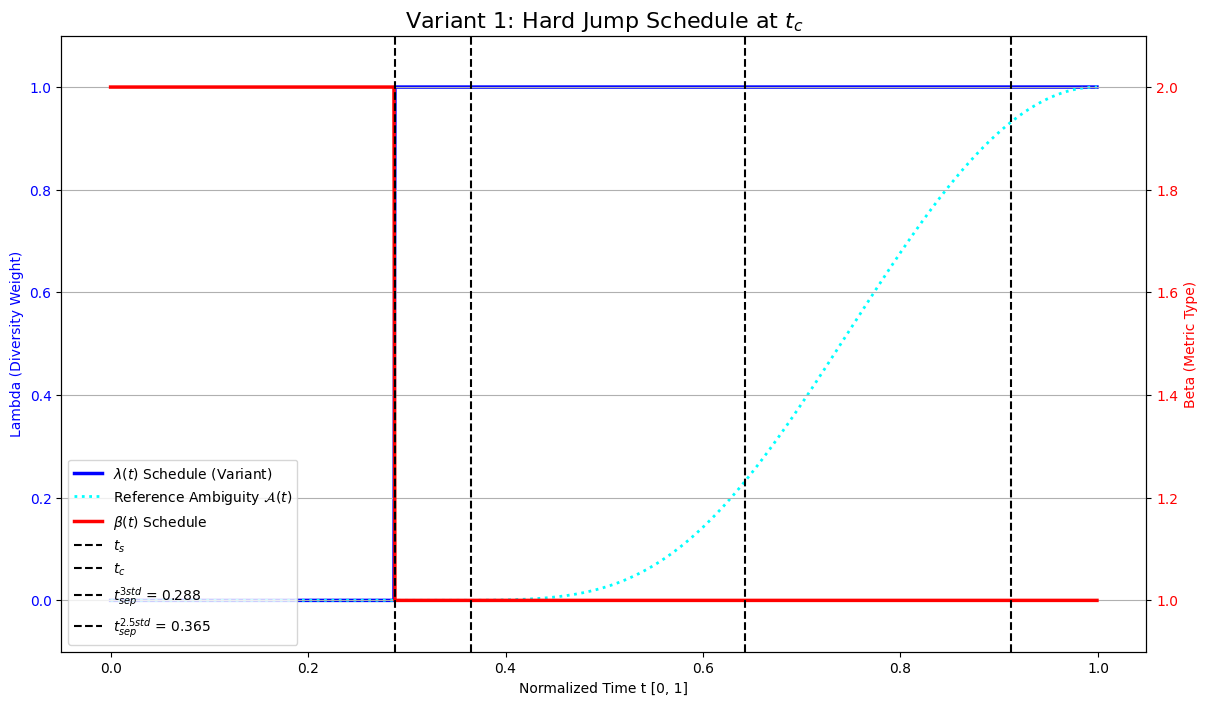

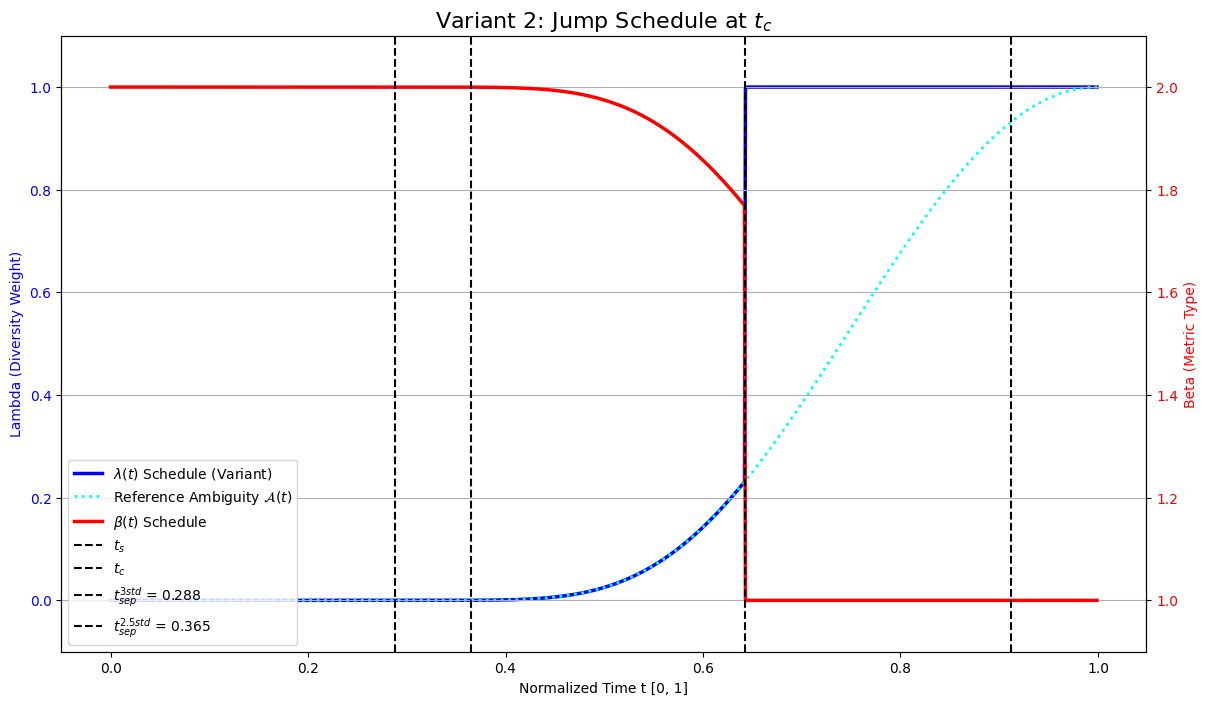

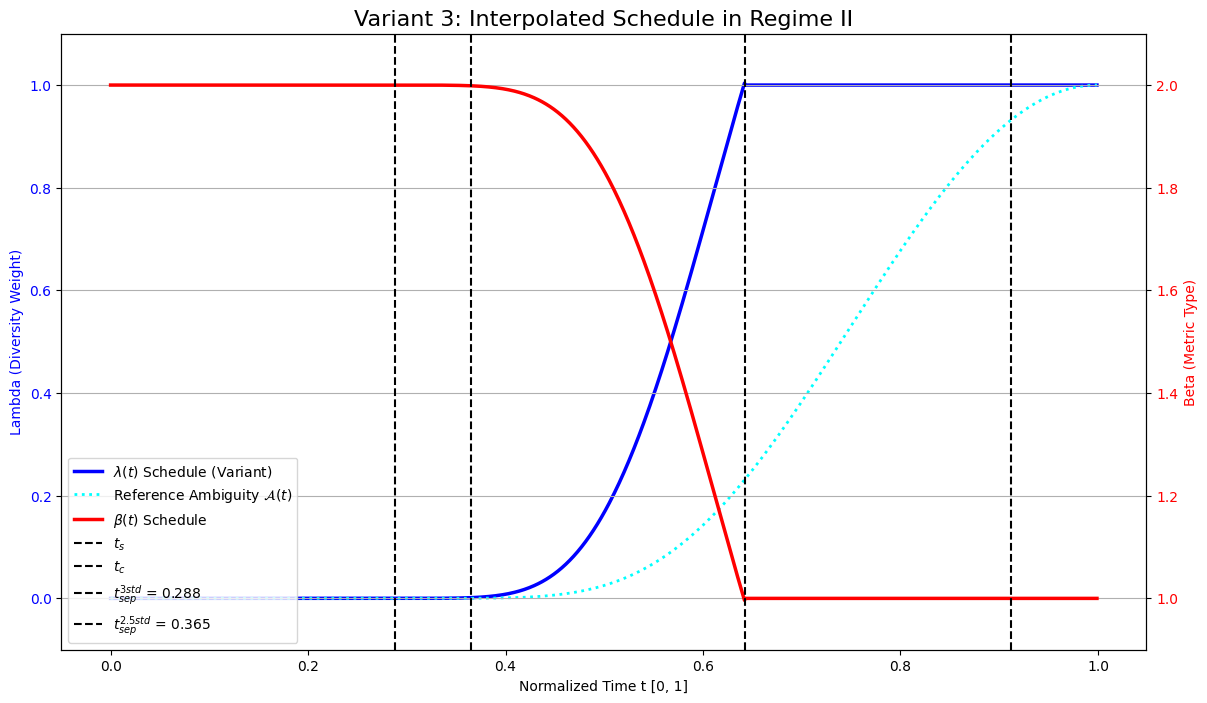

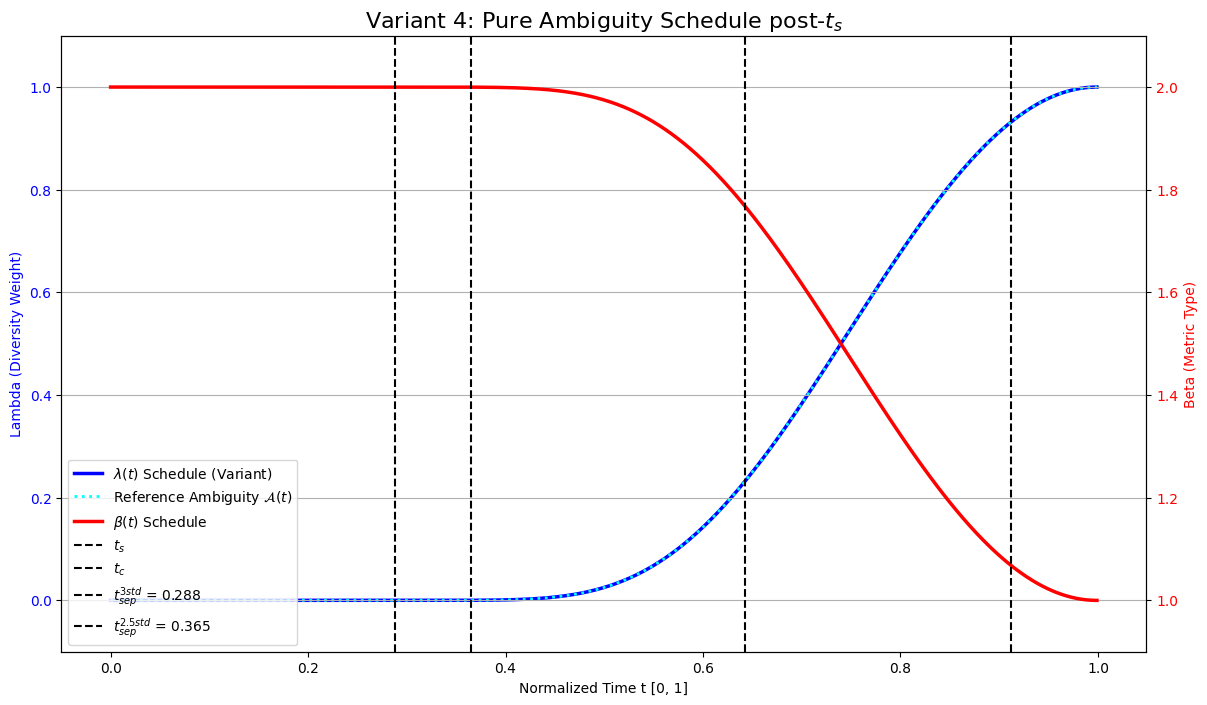

In [91]:
import abc
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from torch import log
from tqdm import tqdm
import time

# ==============================================================================
# 1. ABSTRACT BASE CLASS AND HELPER SCHEDULES (Your Provided Code)
# ==============================================================================

def logsnr_schedule_cosine(t, logsnr_min=-15, logsnr_max=15):
    # Assuming t is a tensor of normalized times [0, 1]
    t_min = math.atan(math.exp(-0.5 * logsnr_max))
    t_max = math.atan(math.exp(-0.5 * logsnr_min))
    return -2 * log(torch.tan(torch.tensor(t_min) + t * (t_max - t_min)))

class LambdaSchedule(abc.ABC):
    """Abstract base class for lambda schedules."""
    def __init__(self, num_timesteps: int):
        self.num_timesteps = num_timesteps
        
    def normalized_t(self, t: torch.Tensor) -> torch.Tensor:
        return t.float() / (self.num_timesteps - 1)

    @abc.abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        pass

# ==============================================================================
# 2. PRE-COMPUTATION AND AMBIGUITY FUNCTIONS
# ==============================================================================

def get_iddpm_alphas_cumprod(num_diffusion_timesteps: int, s: float = 0.008):
    """Generates the exact alphas_cumprod schedule used in iDDPM."""
    t_steps = torch.linspace(0, 1, num_diffusion_timesteps)
    f_t = torch.cos(((t_steps + s) / (1 + s)) * (math.pi / 2)) ** 2
    return f_t / f_t[0]

def ambiguity_ratio(t_biroli: np.ndarray, d: float, eps: float = 1e-20) -> np.ndarray:
    """Calculates the Ambiguity Ratio A(t) for a given unnormalized time t and distance d."""
    denominator = 2 * (np.exp(2 * t_biroli) - 1 + eps)
    exponent = -(d**2) / denominator
    return np.exp(exponent)

def precompute_schedule_values(
    t_c_biroli: float,
    t_s_biroli: float,
    t_sep_biroli: float,
    t_sep_biroli_val_less_strict: float,
    d_min: float,
    num_diffusion_timesteps: int,
    s: float = 0.008,
    eps: float = 1e-20
) -> dict:
    """
    Performs all expensive, one-time calculations for the ambiguity schedules.
    """
    print("--- Pre-computing schedule values ---")
    
    alphas_cumprod = get_iddpm_alphas_cumprod(num_diffusion_timesteps, s).numpy()
    logsnr_schedule = np.log((alphas_cumprod + eps) / (1 - alphas_cumprod + eps))

    def convert_time_to_discrete_step(t_biroli):
        target_logsnr = np.log((np.exp(-2 * t_biroli) + eps) / (1 - np.exp(-2 * t_biroli) + eps))
        return np.argmin(np.abs(logsnr_schedule - target_logsnr))

    T_c = convert_time_to_discrete_step(t_c_biroli)
    T_s = convert_time_to_discrete_step(t_s_biroli)
    T_sep = convert_time_to_discrete_step(t_sep_biroli)
    T_sep_less_strict = convert_time_to_discrete_step(t_sep_biroli_val_less_strict)

    print(f"t_s maps to discrete step T_s = {T_s}")
    print(f"t_c maps to discrete step T_c = {T_c}")
    print(f"t_sep (t_c_strict) maps to discrete step T_sep = {T_sep}")

    def sigmoid(x): return 1 / (1 + np.exp(-x))
    t_biroli_schedule = -0.5 * np.log(sigmoid(logsnr_schedule) + eps)
    
    ambiguity_schedule = ambiguity_ratio(t_biroli_schedule, d=d_min)
    
    return {
        "T_s": T_s,
        "T_c": T_c,
        "T_sep": T_sep,
        "T_sep_less_strict": T_sep_less_strict,
        "ambiguity_schedule": torch.from_numpy(ambiguity_schedule).float()
    }

# ==============================================================================
# 3. NEW LAMBDA SCHEDULE IMPLEMENTATIONS
# ==============================================================================

class HardJumpSchedule(LambdaSchedule):
    """Lambda=1 until t_c, then jumps down to the Ambiguity(t) curve."""
    def __init__(self, num_timesteps: int, precomputed_values: dict):
        super().__init__(num_timesteps)
        self.T_sep = precomputed_values["T_sep"]

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        lambda_vals = torch.ones_like(t, dtype=torch.float32)
        mask = t < self.T_sep
        lambda_vals[mask] = 0
        return lambda_vals

class AmbiguityJumpSchedule(LambdaSchedule):
    """Lambda=1 until t_c, then jumps down to the Ambiguity(t) curve."""
    def __init__(self, num_timesteps: int, precomputed_values: dict):
        super().__init__(num_timesteps)
        self.T_c = precomputed_values["T_c"]
        self.ambiguity_schedule = precomputed_values["ambiguity_schedule"]

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        lambda_vals = torch.ones_like(t, dtype=torch.float32)
        mask = t < self.T_c
        lambda_vals[mask] = self.ambiguity_schedule[t[mask]]
        return lambda_vals

class AmbiguityInterpolatedSchedule(LambdaSchedule):
    """Lambda=1 until t_s, then interpolates to A(t_c), then follows A(t)."""
    def __init__(self, num_timesteps: int, precomputed_values: dict):
        super().__init__(num_timesteps)
        self.T_s = precomputed_values["T_s"]
        self.T_c = precomputed_values["T_c"]
        self.T_sep = precomputed_values["T_sep"]
        self.ambiguity_schedule = precomputed_values["ambiguity_schedule"]
        self.ambiguity_at_tc = self.ambiguity_schedule[self.T_c]

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        lambda_vals = torch.empty_like(t, dtype=torch.float32)
        
        # Regime I (t > t_s)
        mask_I_and_II = t >= self.T_c
        lambda_vals[mask_I_and_II] = 1.0

        # Regime II (t_c <= t < t_s)
        mask_II = (t < self.T_c) & (t >= self.T_sep)
        t_interp = t[mask_II]
        # Linear interpolation weight from 0 (at t_c) to 1 (at t_s)
        alpha = (t_interp.float() - self.T_c) / (self.T_s - self.T_c)
        lambda_vals[mask_II] = (self.ambiguity_schedule[t[mask_II]] / self.ambiguity_schedule[t[mask_II]].max())  * (1 - alpha) # + 1.0 * alpha

        # # Regime III (t < t_c)
        # mask_III = t < self.T_c
        # lambda_vals[mask_III] = self.ambiguity_schedule[t[mask_III]]
        
        # Regime IIIb (t < t_sep)
        mask_IIIb = t < self.T_sep
        lambda_vals[mask_IIIb] = 0.0
        
        return lambda_vals

class AmbiguityPureSchedule(LambdaSchedule):
    """Lambda=1 until t_s, then follows the Ambiguity(t) curve."""
    def __init__(self, num_timesteps: int, precomputed_values: dict):
        super().__init__(num_timesteps)
        self.T_s = precomputed_values["T_s"]
        self.ambiguity_schedule = precomputed_values["ambiguity_schedule"]

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        lambda_vals = torch.ones_like(t, dtype=torch.float32)
        # mask = t < self.T_s
        # lambda_vals[mask] = self.ambiguity_schedule[t[mask]]
        lambda_vals = self.ambiguity_schedule[t]
        return lambda_vals

# ==============================================================================
# 4. BETA SCHEDULE WRAPPER
# ==============================================================================

class BetaSchedule(LambdaSchedule):
    """A wrapper that computes beta from a given lambda schedule."""
    def __init__(self, lambda_schedule: LambdaSchedule, beta_start: float = 1.0):
        super().__init__(lambda_schedule.num_timesteps)
        self.lambda_schedule = lambda_schedule
        self.beta_start = beta_start
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        lambda_vals = self.lambda_schedule(t)
        return self.beta_start * lambda_vals + 2.0 * (1 - lambda_vals)

# ==============================================================================
# 5. PLOTTING AND DEMONSTRATION
# ==============================================================================

# def plot_schedules(lambda_schedule: LambdaSchedule, beta_schedule: BetaSchedule, precomputed_values: dict, title: str):
#     """Helper function to generate a dual-axis plot for a given schedule pair."""
#     T = lambda_schedule.num_timesteps
#     t_axis = torch.arange(T)
    
#     lambda_vals = lambda_schedule(t_axis)
#     beta_vals = beta_schedule(t_axis)
    
#     fig, ax1 = plt.subplots(figsize=(14, 8))
    
#     ax1.plot(t_axis.numpy() / T, lambda_vals.numpy(), 'b-', label='$\lambda(t)$ Schedule')
#     ax1.set_xlabel("Normalized Time t [0, 1]")
#     ax1.set_ylabel("Lambda (Diversity Weight)", color='b')
#     ax1.tick_params(axis='y', labelcolor='b')
#     ax1.set_ylim(-0.1, 1.1)
    
#     ax2 = ax1.twinx()
#     ax2.plot(t_axis.numpy() / T, beta_vals.numpy(), 'r-', label='$\\beta(t)$ Schedule')
#     ax2.set_ylabel("Beta (Metric Type)", color='r')
#     ax2.tick_params(axis='y', labelcolor='r')
#     ax2.set_ylim(beta_schedule.beta_start - 0.1, 2.1)

#     # Add vertical lines for regime boundaries
#     T_s = precomputed_values["T_s"]
#     T_c = precomputed_values["T_c"]
#     T_sep = precomputed_values["T_sep"]
    
#     plt.axvline(x=T_s / T, color='k', linestyle='--', label=f'$t_s$')
#     plt.axvline(x=T_c / T, color='k', linestyle='--', label=f'$t_c$')
#     plt.axvline(x=T_sep / T, color='k', linestyle='--', label=f'$t_c$ strict')

#     plt.title(title, fontsize=16)
#     fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
#     plt.grid(True)
#     plt.show()

def plot_schedules(lambda_schedule: LambdaSchedule, beta_schedule: BetaSchedule, precomputed_values: dict, title: str):
    """
    Helper function to generate a dual-axis plot for a given schedule pair,
    with the pure ambiguity curve superimposed for reference.
    """
    T = lambda_schedule.num_timesteps
    t_axis = torch.arange(T)
    
    # Calculate the schedules to be plotted
    lambda_vals = lambda_schedule(t_axis)
    beta_vals = beta_schedule(t_axis)
    
    # Get the reference ambiguity schedule from precomputed values
    ambiguity_reference = precomputed_values["ambiguity_schedule"]

    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # --- Primary Y-Axis (Lambda) ---
    color_lambda = 'b'
    ax1.set_xlabel("Normalized Time t [0, 1]")
    ax1.set_ylabel("Lambda (Diversity Weight)", color=color_lambda)
    
    # Plot the main lambda schedule for this variant
    ax1.plot(t_axis.numpy() / T, lambda_vals.numpy(), color=color_lambda, linestyle='-', linewidth=2.5, label='$\lambda(t)$ Schedule (Variant)')
    
    # Superimpose the pure ambiguity curve for reference
    ax1.plot(t_axis.numpy() / T, ambiguity_reference.numpy(), color='cyan', linestyle=':', linewidth=2, label='Reference Ambiguity $\mathcal{A}(t)$')

    ax1.tick_params(axis='y', labelcolor=color_lambda)
    ax1.set_ylim(-0.1, 1.1)
    
    # --- Secondary Y-Axis (Beta) ---
    ax2 = ax1.twinx()
    color_beta = 'r'
    ax2.plot(t_axis.numpy() / T, beta_vals.numpy(), color=color_beta, linestyle='-', linewidth=2.5, label='$\\beta(t)$ Schedule')
    ax2.set_ylabel("Beta (Metric Type)", color=color_beta)
    ax2.tick_params(axis='y', labelcolor=color_beta)
    ax2.set_ylim(beta_schedule.beta_start - 0.1, 2.1)

    # --- Vertical Lines for Regime Boundaries ---
    T_s = precomputed_values["T_s"]
    T_c = precomputed_values["T_c"]
    T_sep = precomputed_values["T_sep"]
    T_sep_less_strict = precomputed_values["T_sep_less_strict"]
    
    plt.axvline(x=T_s / T, color='k', linestyle='--', label=f'$t_s$')
    plt.axvline(x=T_c / T, color='k', linestyle='--', label=f'$t_c$')
    plt.axvline(x=T_sep / T, color='k', linestyle='--', label='$t_{sep}^{3 std}$ = ' + str(T_sep/T))
    plt.axvline(x=T_sep_less_strict / T, color='k', linestyle='--', label='$t_{sep}^{2.5 std}$ = ' + str(T_sep_less_strict/T))

    plt.title(title, fontsize=16)
    
    # --- Combined Legend ---
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    # --- Configuration ---
    NUM_TIMESTEPS = 1000
    BETA_START = 1.0
    
    # Use placeholder values for characteristic times and d_min
    # In a real run, these would be computed from the dataset
    t_s_biroli_val = 2
    t_c_biroli_val = 0.64
    t_sep_biroli_val = 0.1106
    t_sep_biroli_val_less_strict = 0.180
    d_min_val = 2.750

    # --- 1. Pre-compute all necessary values once ---
    precomputed = precompute_schedule_values(
        t_c_biroli=t_c_biroli_val,
        t_s_biroli=t_s_biroli_val,
        t_sep_biroli=t_sep_biroli_val,
        t_sep_biroli_val_less_strict=t_sep_biroli_val_less_strict,
        d_min=d_min_val,
        num_diffusion_timesteps=NUM_TIMESTEPS
    )

    # --- 2. Instantiate and plot each schedule variant ---
    
    # Variant 1: Hard Jump Schedule
    lambda_jump = HardJumpSchedule(NUM_TIMESTEPS, precomputed)
    beta_jump = BetaSchedule(lambda_jump, BETA_START)
    plot_schedules(lambda_jump, beta_jump, precomputed, "Variant 1: Hard Jump Schedule at $t_c$")
    
    # Variant 2: Jump Schedule
    lambda_jump = AmbiguityJumpSchedule(NUM_TIMESTEPS, precomputed)
    beta_jump = BetaSchedule(lambda_jump, BETA_START)
    plot_schedules(lambda_jump, beta_jump, precomputed, "Variant 2: Jump Schedule at $t_c$")

    # Variant 3: Interpolated Schedule
    lambda_interp = AmbiguityInterpolatedSchedule(NUM_TIMESTEPS, precomputed)
    beta_interp = BetaSchedule(lambda_interp, BETA_START)
    plot_schedules(lambda_interp, beta_interp, precomputed, "Variant 3: Interpolated Schedule in Regime II")

    # Variant 4: Pure Ambiguity Schedule
    lambda_pure = AmbiguityPureSchedule(NUM_TIMESTEPS, precomputed)
    beta_pure = BetaSchedule(lambda_pure, BETA_START)
    plot_schedules(lambda_pure, beta_pure, precomputed, "Variant 4: Pure Ambiguity Schedule post-$t_s$")